# PCA and Clustering

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Principal-component-analysis" data-toc-modified-id="Principal-component-analysis-1">Principal component analysis</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-2">Load the data</a></span></li><li><span><a href="#Determine-the-baseline" data-toc-modified-id="Determine-the-baseline-3">Determine the baseline</a></span></li><li><span><a href="#Standardize-and-create-a-train-test-split" data-toc-modified-id="Standardize-and-create-a-train-test-split-4">Standardize and create a train-test split</a></span></li><li><span><a href="#Transformation-to-principal-components" data-toc-modified-id="Transformation-to-principal-components-5">Transformation to principal components</a></span></li><li><span><a href="#Scree-plot" data-toc-modified-id="Scree-plot-6">Scree plot</a></span></li><li><span><a href="#Grid-search-a-logistic-regression-model" data-toc-modified-id="Grid-search-a-logistic-regression-model-7">Grid search a logistic regression model</a></span></li><li><span><a href="#Retaining-only-two-components" data-toc-modified-id="Retaining-only-two-components-8">Retaining only two components</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-9">Clustering</a></span><ul class="toc-item"><li><span><a href="#K-Means" data-toc-modified-id="K-Means-9.1">K-Means</a></span></li><li><span><a href="#Hierarchical-clustering" data-toc-modified-id="Hierarchical-clustering-9.2">Hierarchical clustering</a></span></li><li><span><a href="#DBSCAN" data-toc-modified-id="DBSCAN-9.3">DBSCAN</a></span></li></ul></li></ul></div>

## Principal component analysis

In principal component analysis we perform a coordinate transformation of the data so that the new coordinates are better adapted to the data in the sense of being aligned with the directions of highest variance of the data. The coordinate transformation will not change anything about the predictions that we are going to make. However, the transformation is constructed in such a way that the new features will be completely uncorrelated. For a very good demonstration, see [setosa.io](http://setosa.io/ev/principal-component-analysis/).

The crucial change happens when we decide to neglect the new coordinate directions with lowest  variance. In principal then we might loose information, but less so if before the transformation features were strongly correlated. Even though our training scores will become worse, we might get better generalization performance.

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.simplefilter('ignore')

In [2]:
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

## Load the data

We will work with another famous dataset about breast cancer. It contains different characteristics about tumors which have been labeled as either malign or benign.

In [3]:
data = datasets.load_breast_cancer()

In [4]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [5]:
X = pd.DataFrame(data.data, columns=data.feature_names)
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Determine the baseline

In [6]:
y = pd.Series(data.target)
y.value_counts(normalize=True)

1    0.627417
0    0.372583
dtype: float64

## Standardize and create a train-test split

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=1)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

Note the correlations among the features.

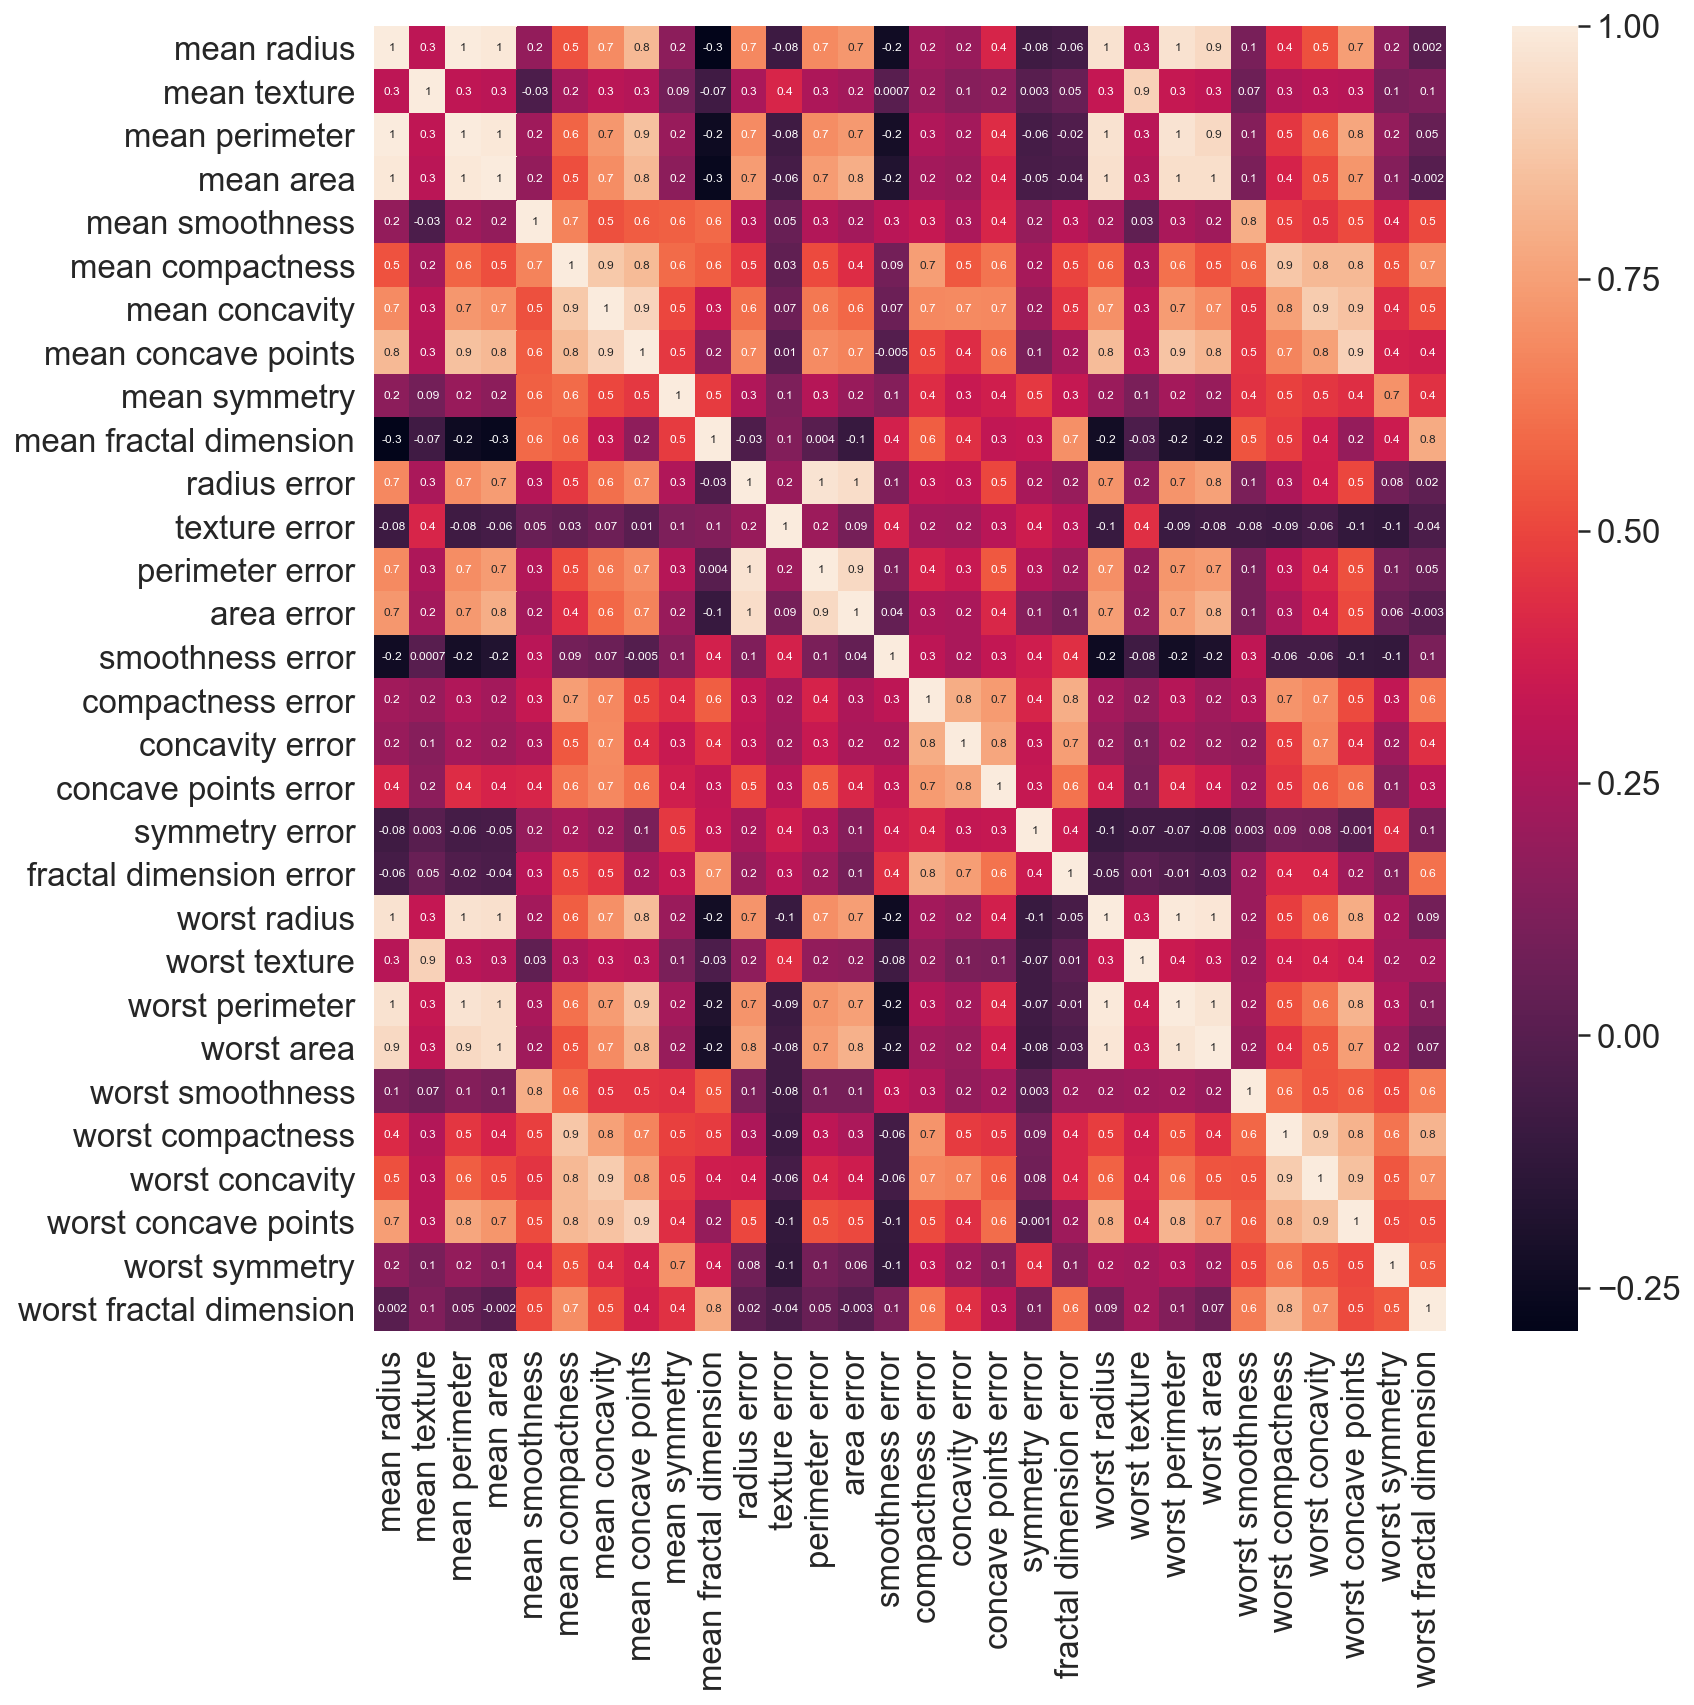

In [8]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(X_train.corr(), annot=True, fmt='.1g',
            ax=ax, annot_kws={'fontsize': 6})
plt.show()

In [9]:
import scikitplot as skplt
from sklearn import metrics

from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

## Transformation to principal components

Now we are going to carry out the transformation to principal components using scikit-learn, but for now we are going to retain all the components. 

In [10]:
from sklearn.decomposition import PCA

In [11]:
X.shape[1]

30

In [12]:
pca = PCA(n_components=X.shape[1])
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)
X_pca_train.shape

(455, 30)

Note that now there are no correlations among the features expressed in the new coordinates any more. That serves as a quick check. If you see something else, you have not done PCA!

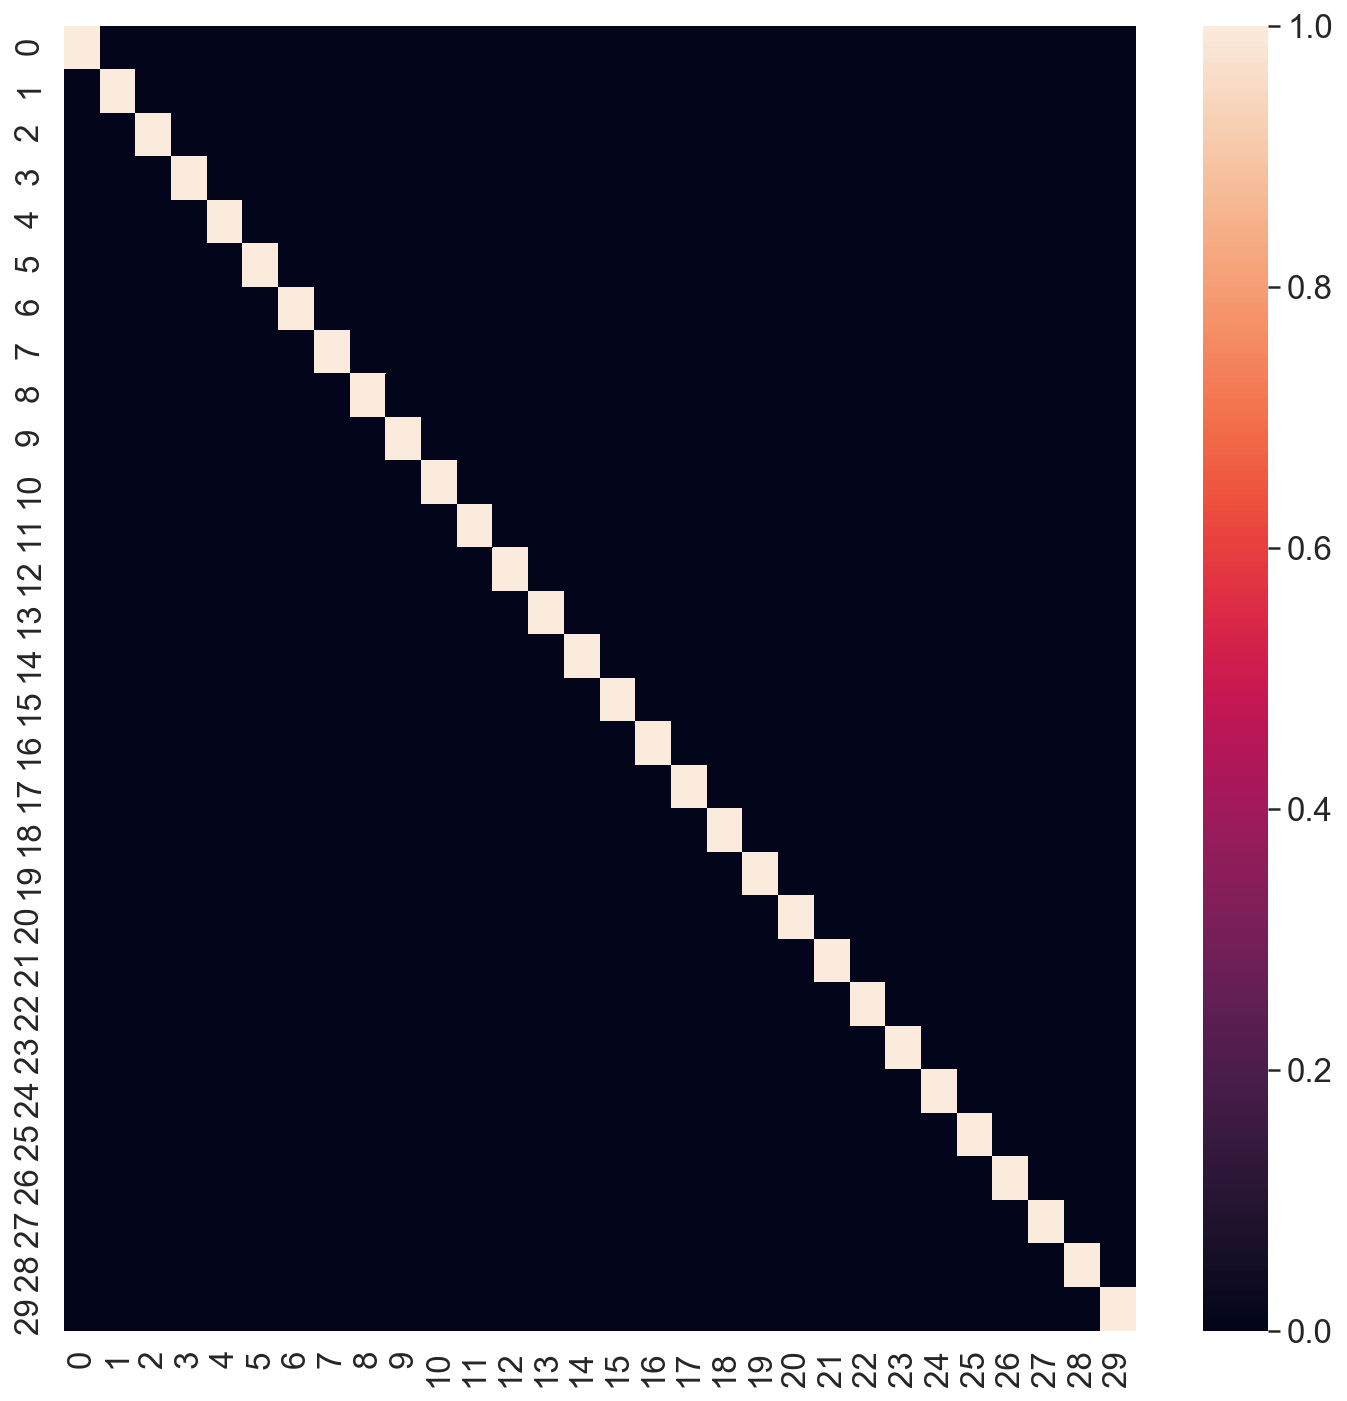

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(np.corrcoef(X_pca_train.T), annot=False,ax=ax)
plt.show()

After fitting, the dictionary between old and new coordinate directions is contained in the `.components_` attribute. The rows in this matrix are the eigenvectors of the covariance matrix of the features. Their direction is fixed, but their length is not. Scikit-learn returns them with length normalized to one, as you can see from the following plot.

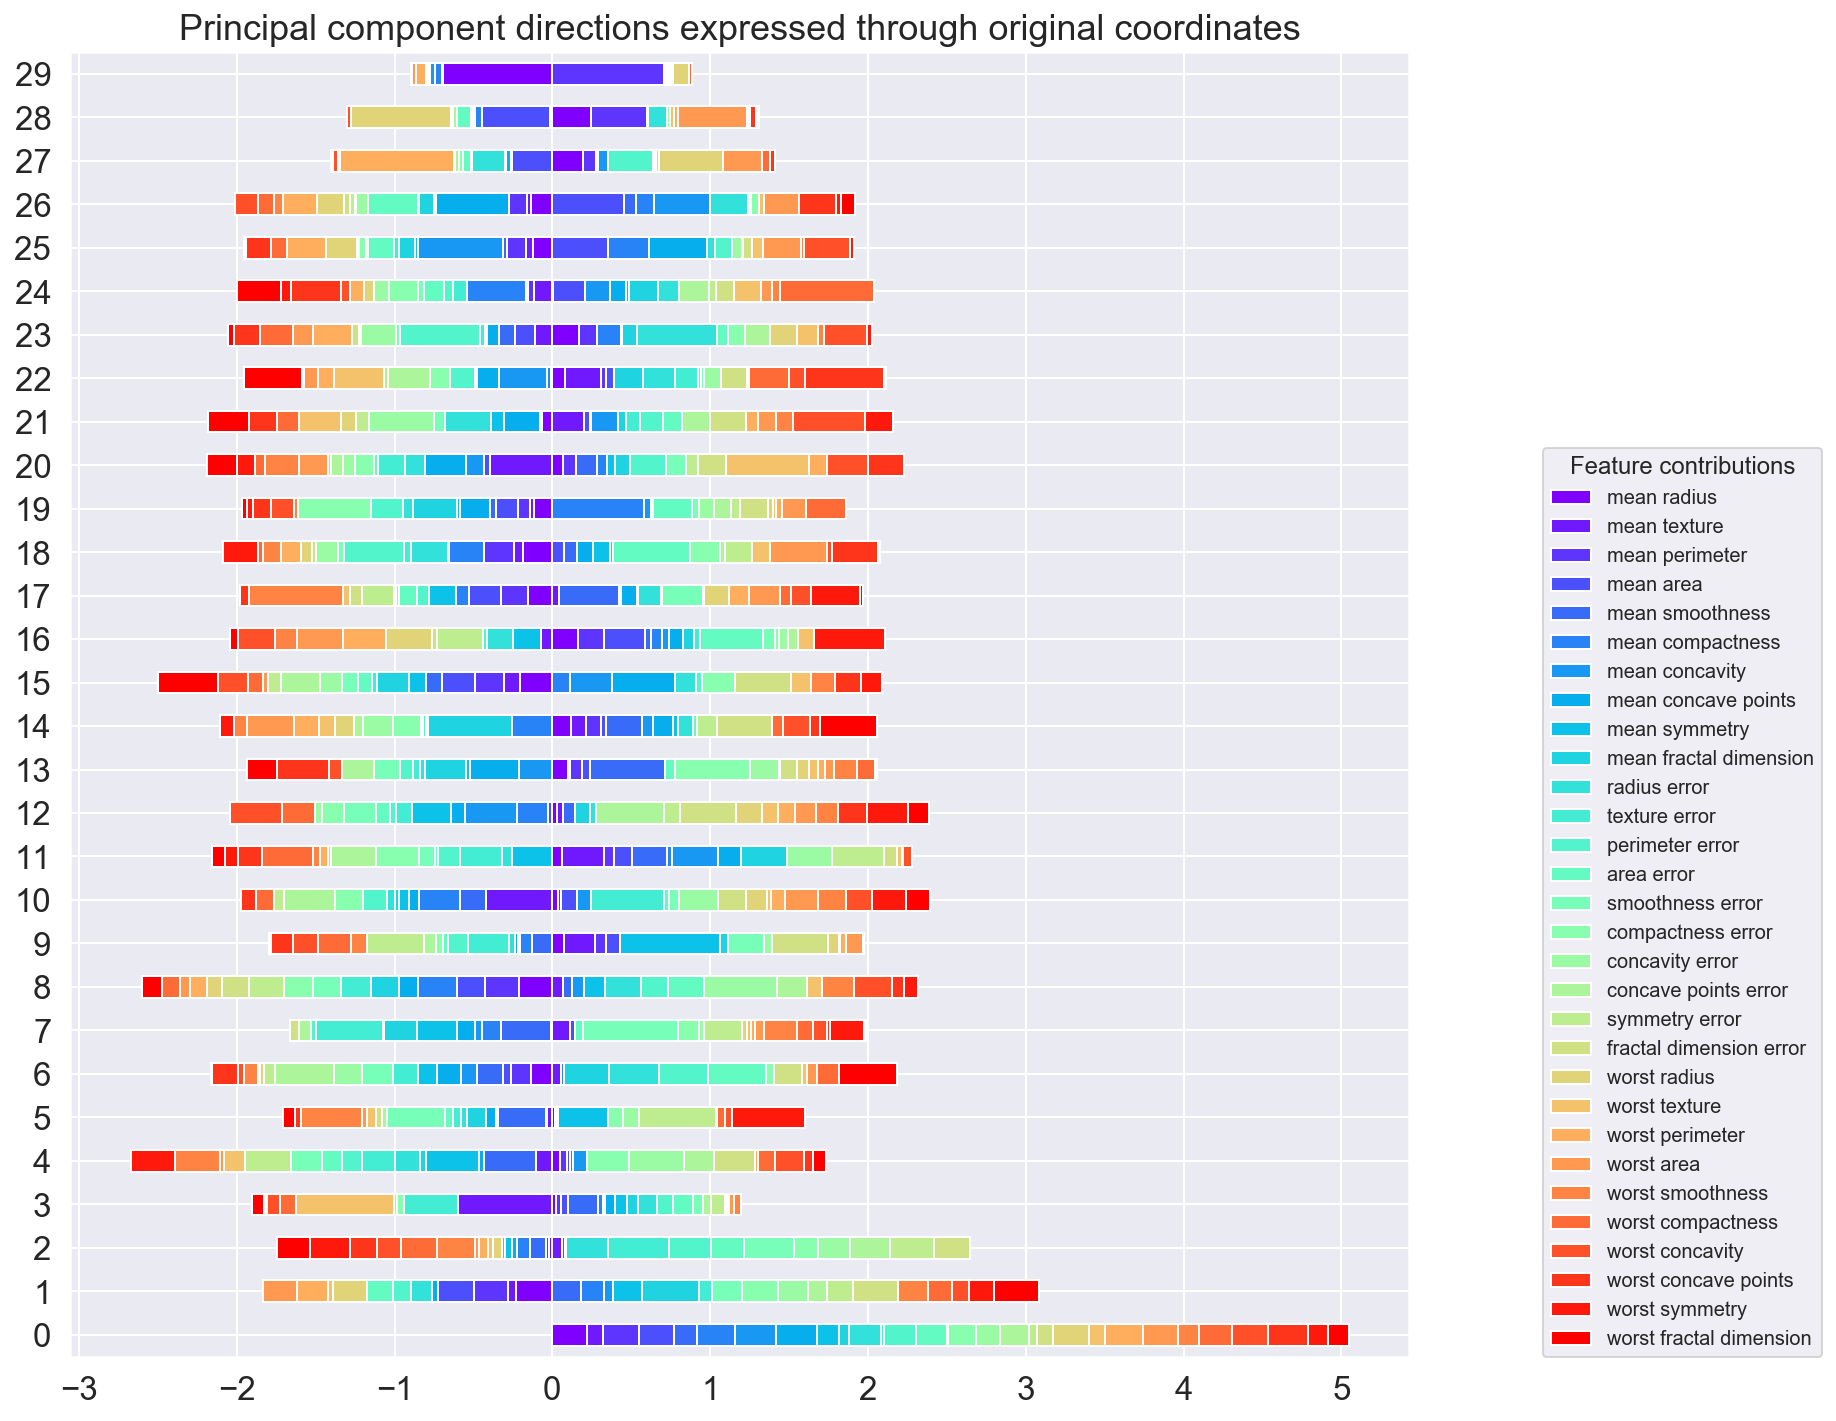

In [14]:
fig, ax = plt.subplots(figsize=(12, 12))
pd.DataFrame(pca.components_, index=list(range(X.shape[1])), columns=X.columns
             ).plot(kind='barh', stacked=True, ax=ax, cmap='rainbow')
ax.legend(loc=[1.1, 0], fontsize=10, title_fontsize=12, title='Feature contributions')
ax.set_title('Principal component directions expressed through original coordinates')
plt.show()

We can illustrate how much each principal component contributes to the original features. In most cases it is challenging to associate features and principal components (unless you don't rescale, please alway do that!).

In [15]:
# eigenvectors are normalized to length one
(pca.components_**2).sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

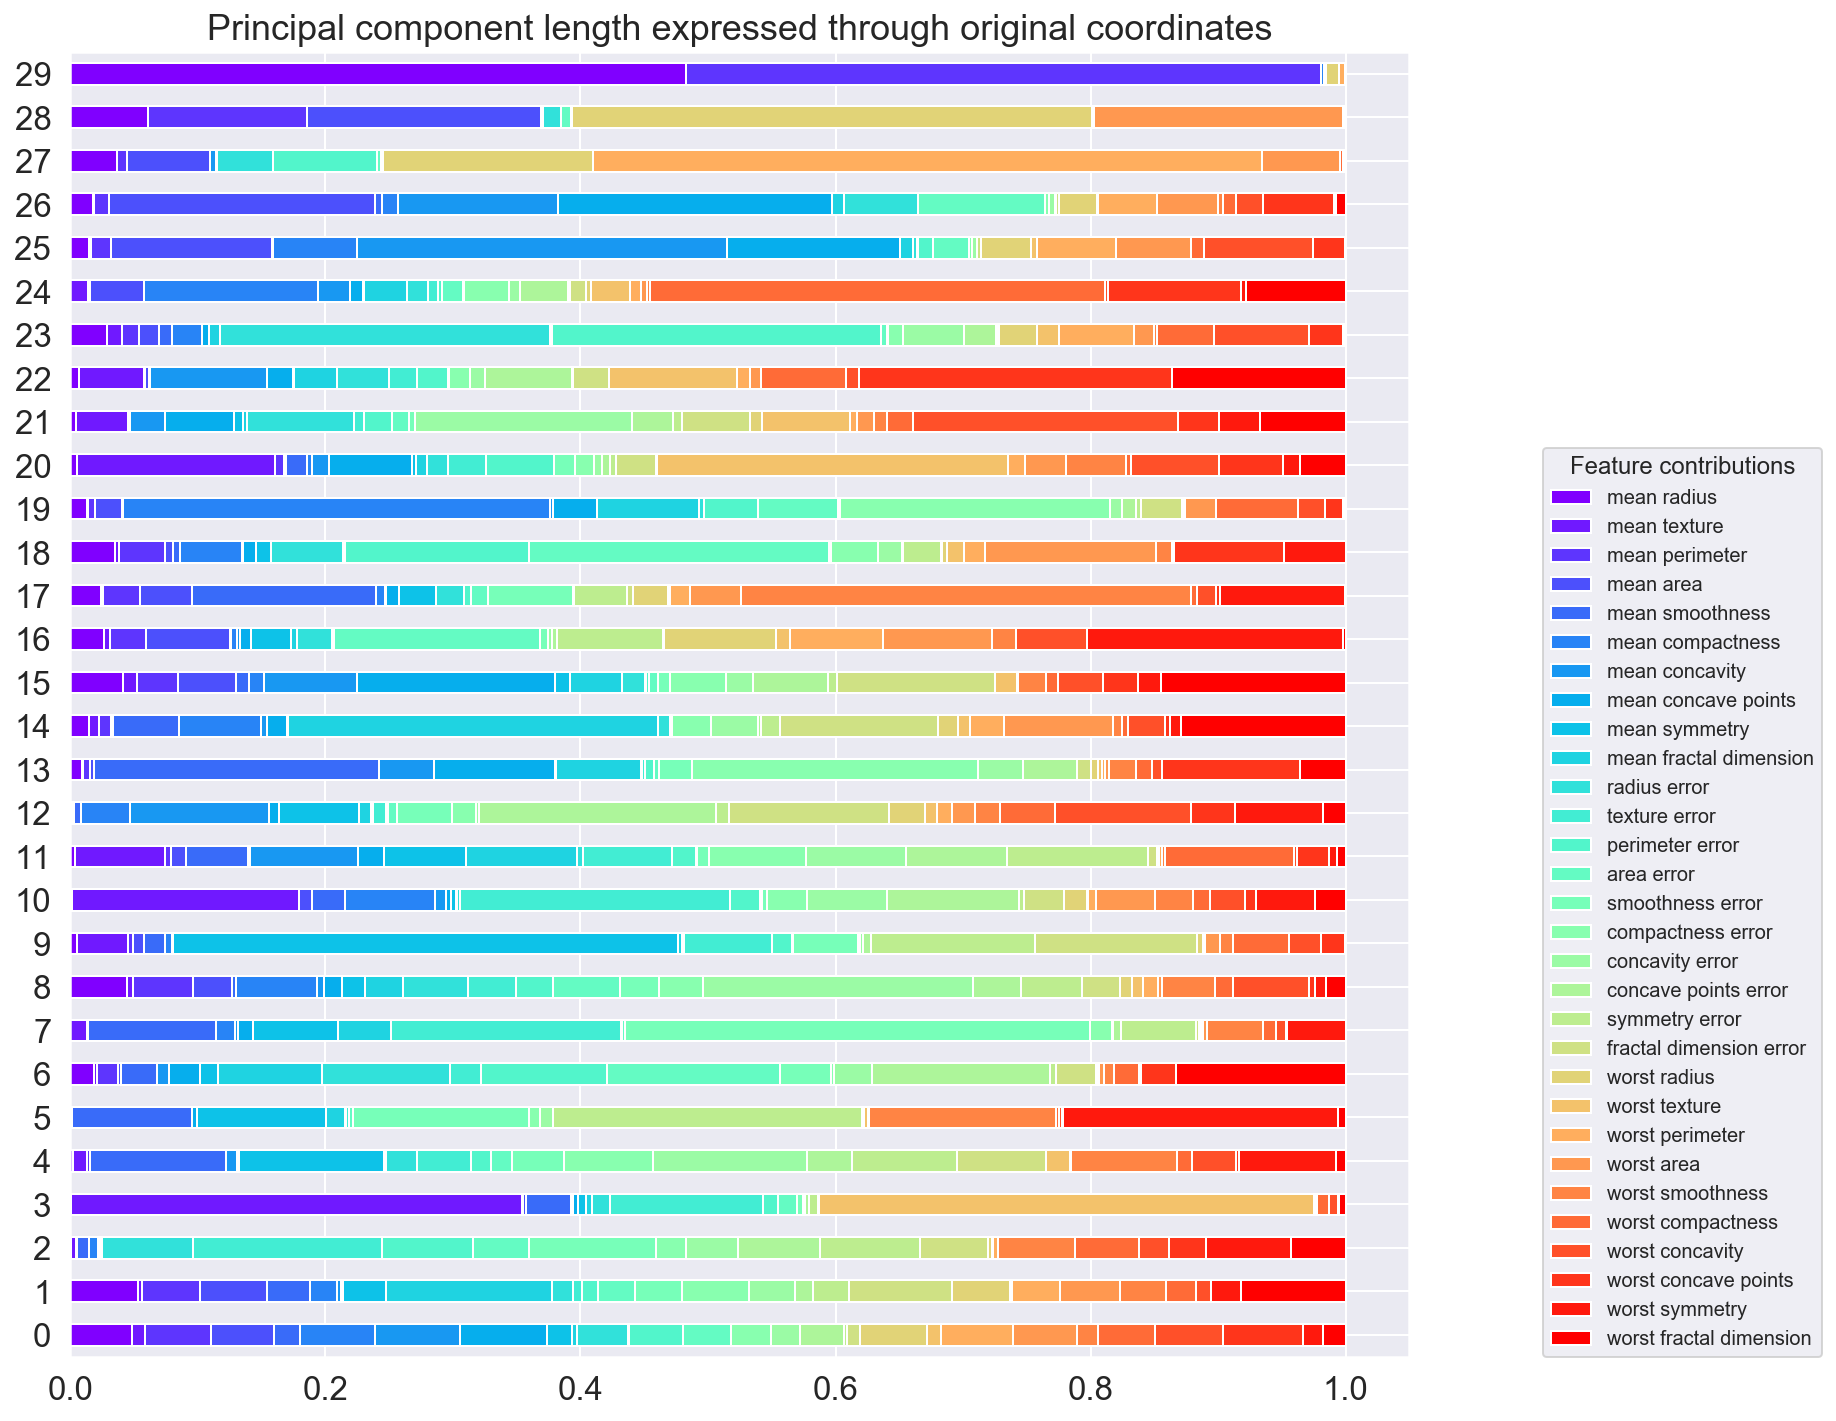

In [16]:
fig, ax = plt.subplots(figsize=(12, 12))
pd.DataFrame(pca.components_**2, index=list(range(X.shape[1])), columns=X.columns
             ).plot(kind='barh', stacked=True, ax=ax, cmap='rainbow')
ax.legend(loc=[1.1, 0], fontsize=10, title_fontsize=12, title='Feature contributions')
ax.set_title('Principal component length expressed through original coordinates')
plt.show()

The same plots showing only a few of the components:

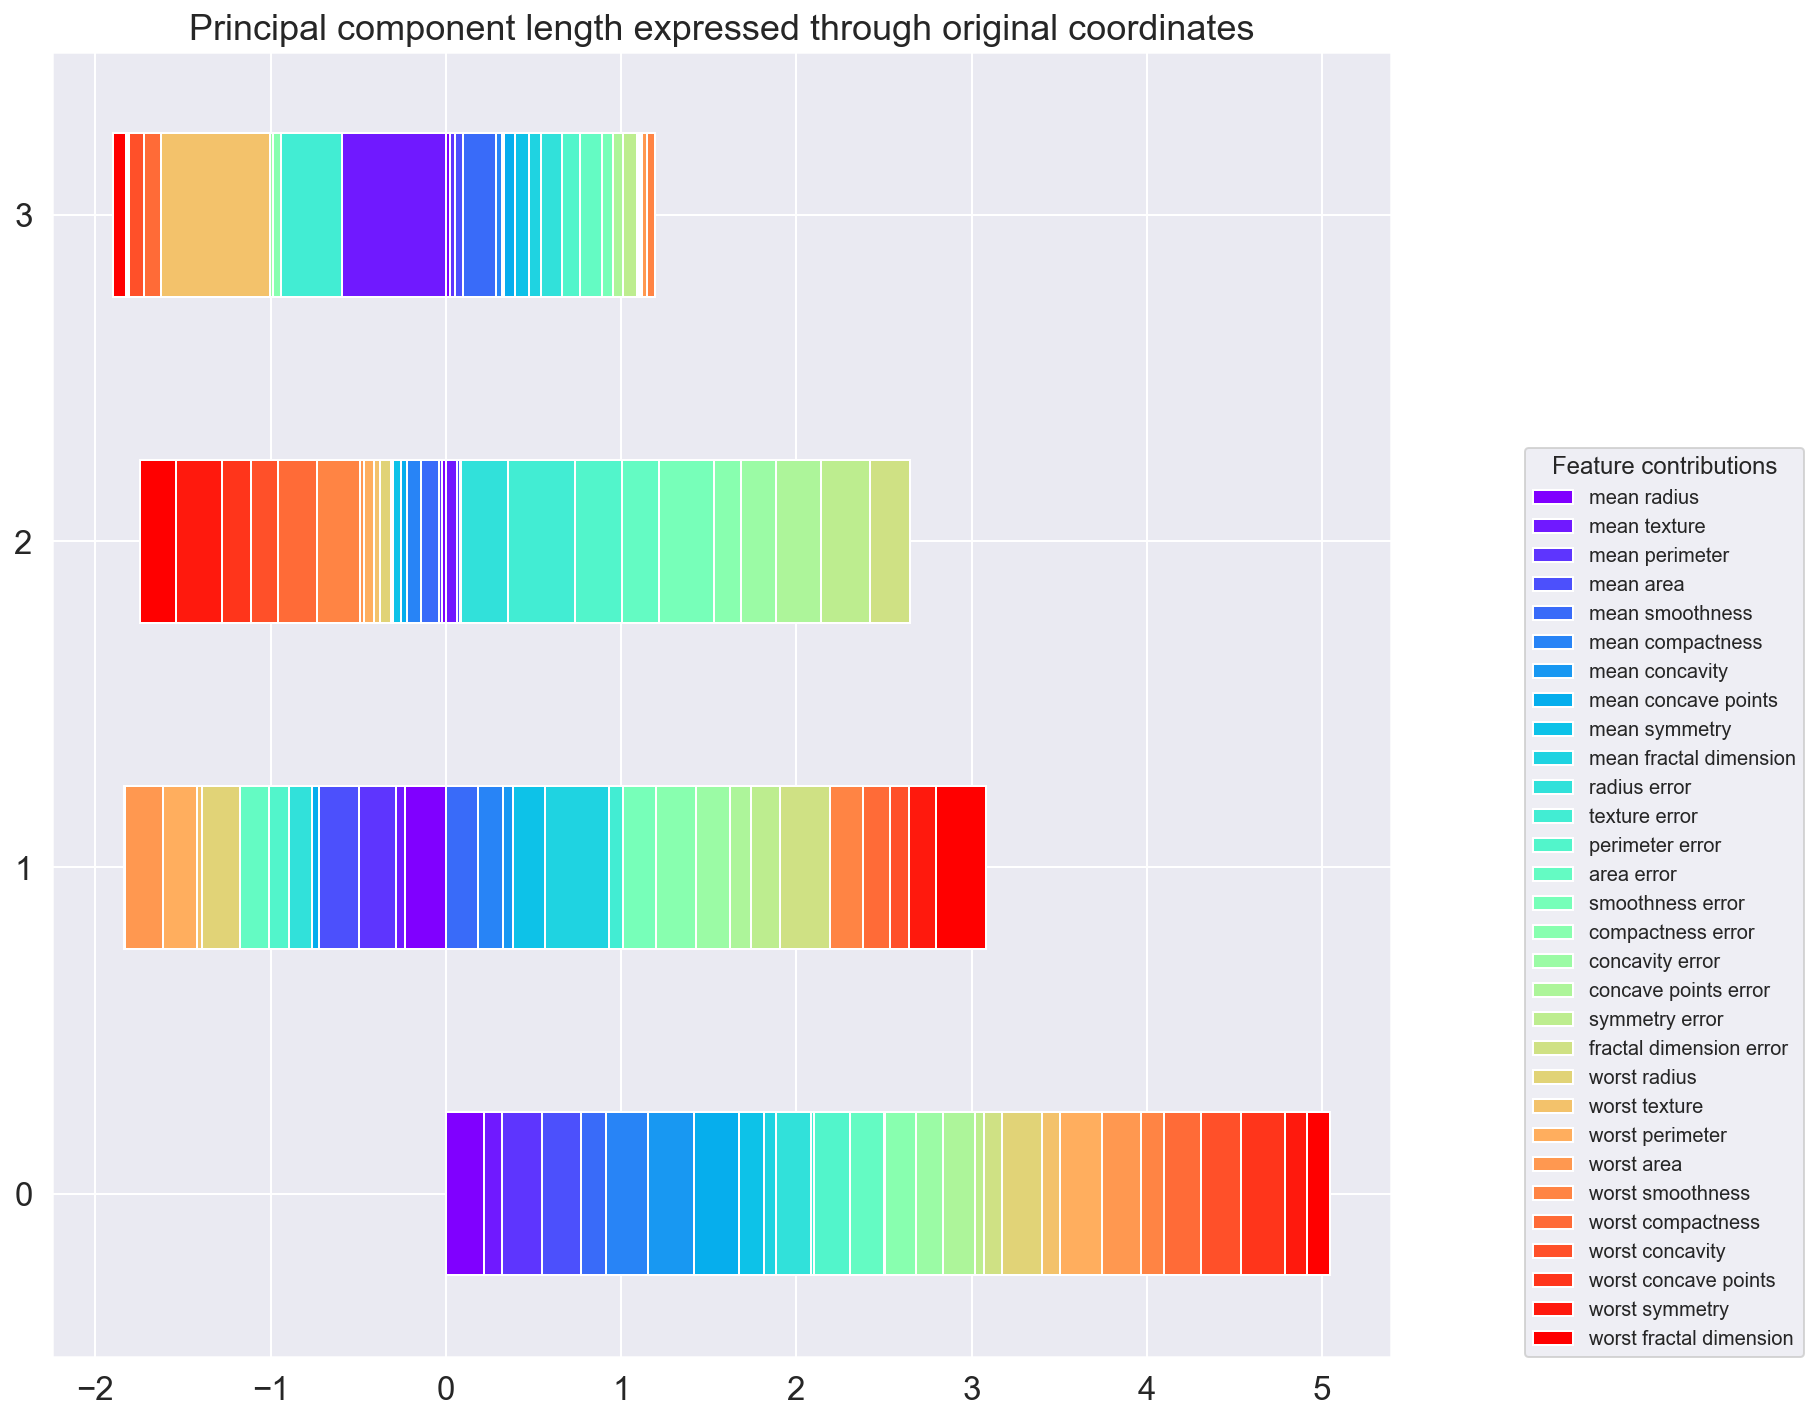

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))
pd.DataFrame(pca.components_, index=list(range(X.shape[1])), columns=X.columns
             ).iloc[:4].plot(kind='barh', stacked=True, ax=ax, cmap='rainbow')
ax.legend(loc=[1.1, 0], fontsize=10, title_fontsize=12, title='Feature contributions')
ax.set_title('Principal component length expressed through original coordinates')
plt.show()

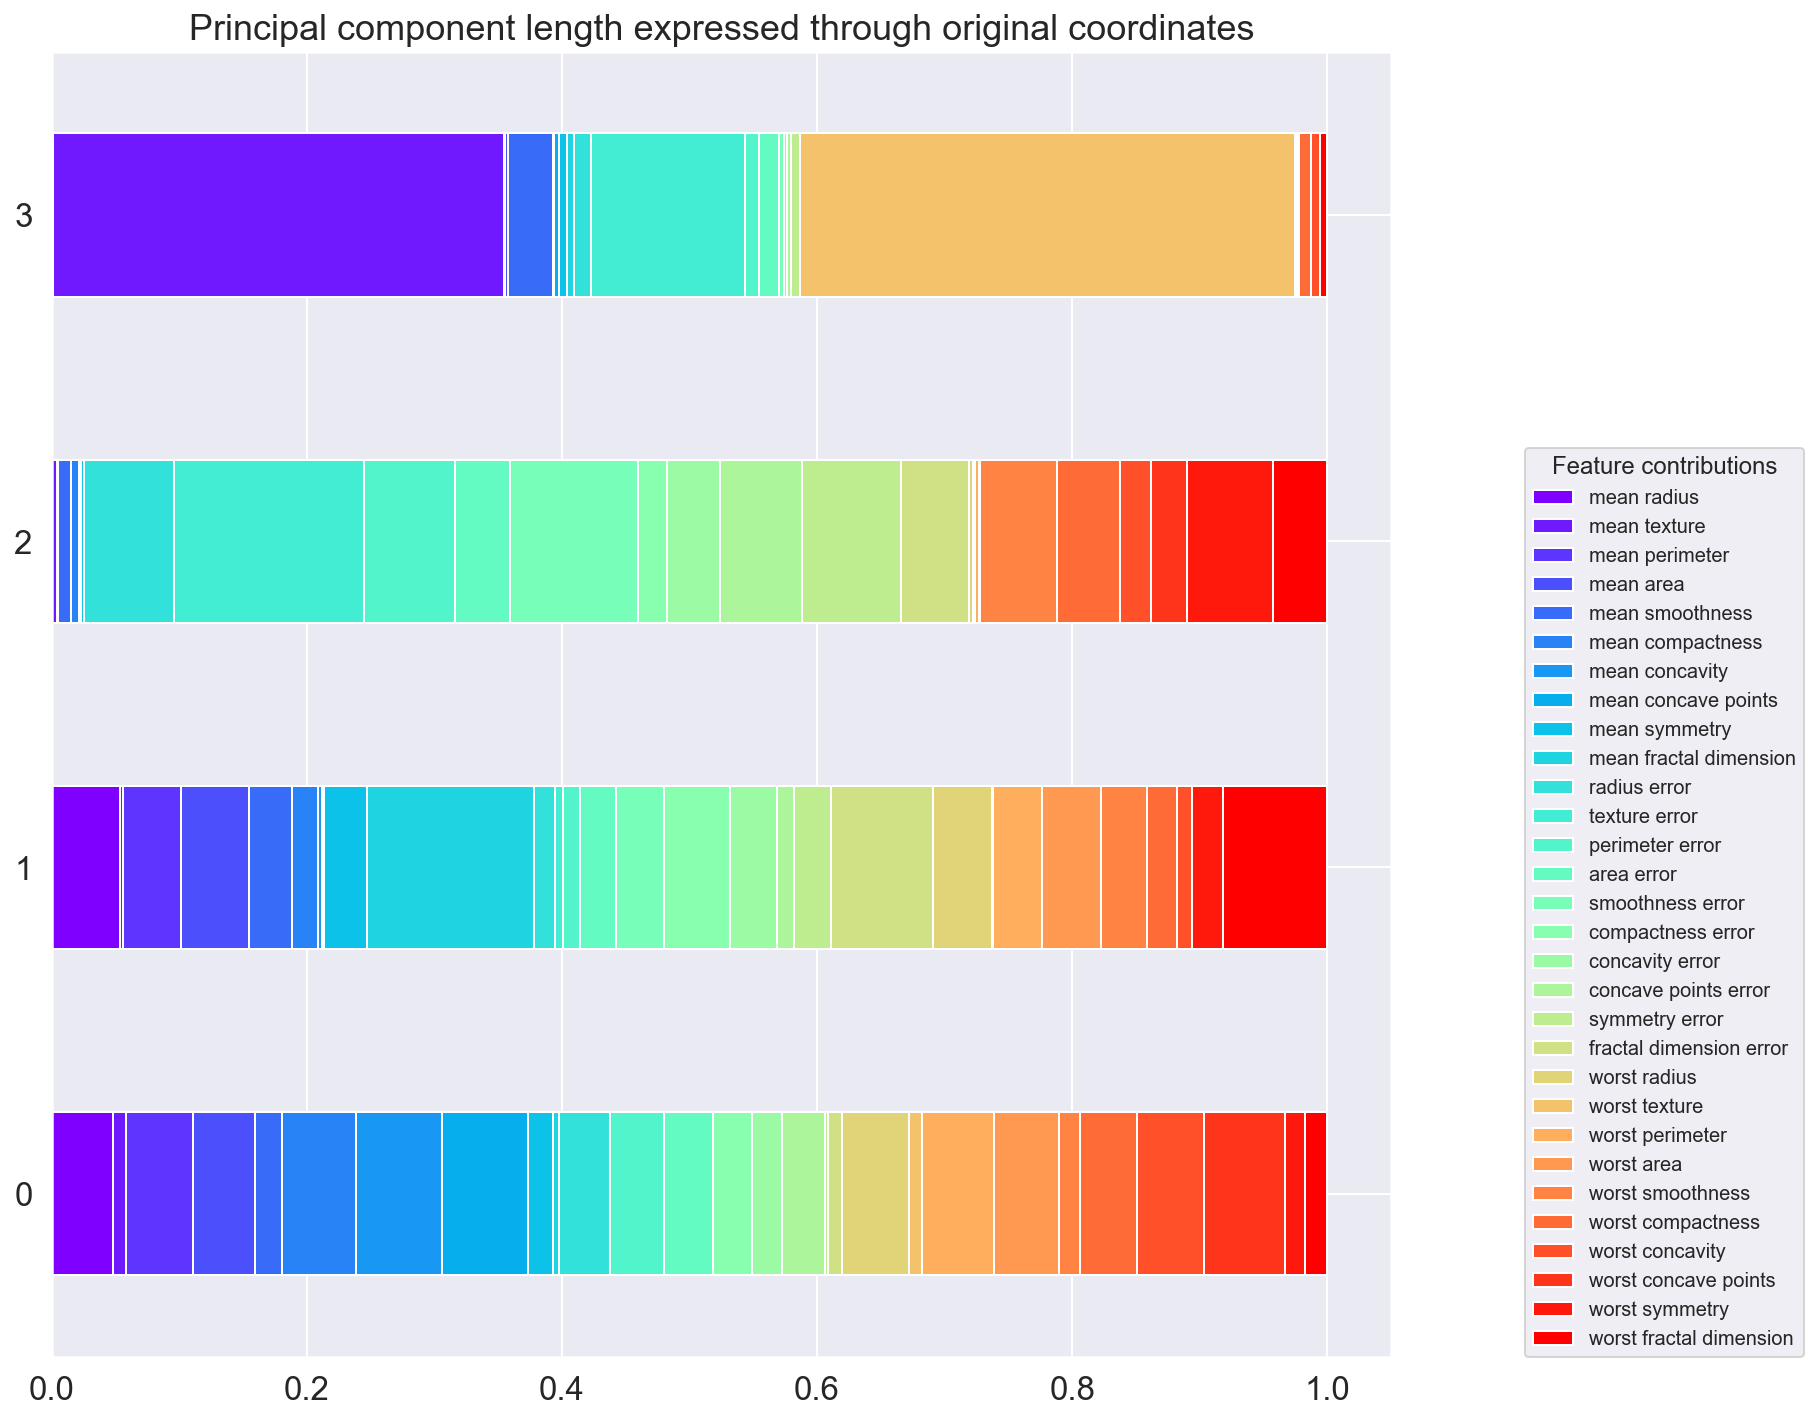

In [18]:
fig, ax = plt.subplots(figsize=(12, 12))
pd.DataFrame(pca.components_**2, index=list(range(X.shape[1])), columns=X.columns
             ).iloc[:4].plot(kind='barh', stacked=True, ax=ax, cmap='rainbow')
ax.legend(loc=[1.1, 0], fontsize=10, title_fontsize=12, title='Feature contributions')
ax.set_title('Principal component length expressed through original coordinates')
plt.show()

We can express the relation also the other way round.

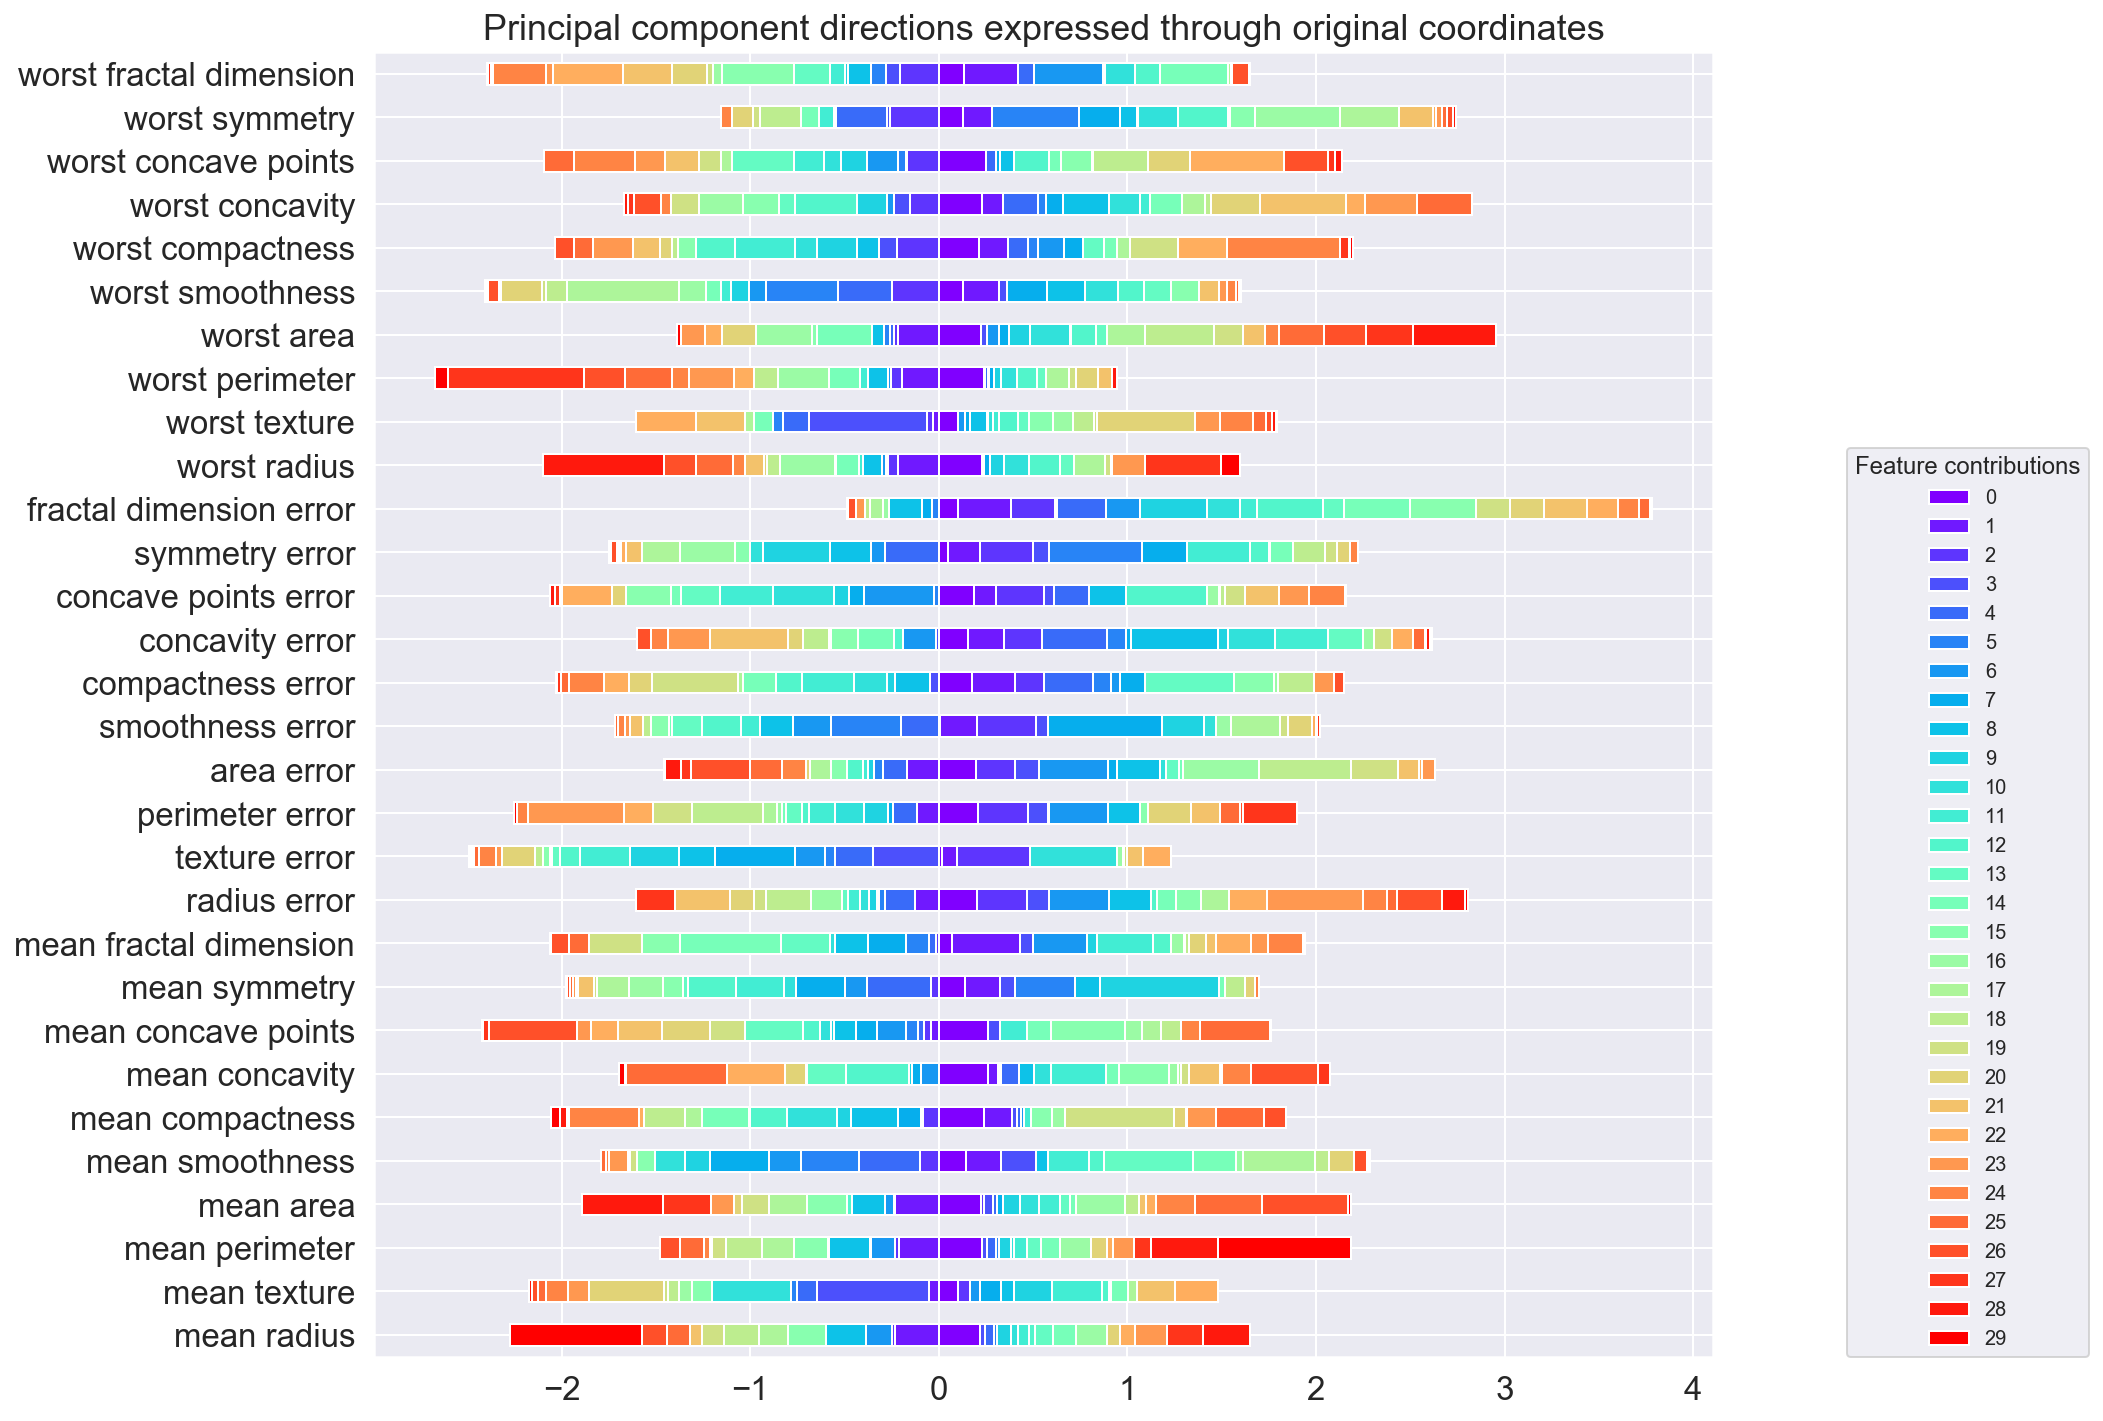

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))
pd.DataFrame(pca.components_.T, columns=list(range(X.shape[1])), index=X.columns
             ).plot(kind='barh', stacked=True, ax=ax, cmap='rainbow')
ax.legend(loc=[1.1, 0], fontsize=10, title_fontsize=12, title='Feature contributions')
ax.set_title('Principal component directions expressed through original coordinates')
plt.show()

## Scree plot

The variance of the data in the new coordinate directions defines a ranking of the new features. We would like to discard the least important features. A scree plot serves for this purpose.
It shows the explained variance ratio of each of the new coordinate directions as well as the cumulative sum of these variances. If the decrease/increase is strong initially and then becomes very flat (an elbow like structure) we can safely neglect all the features in the flat part.

In [20]:
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([4.42667110e-01, 1.90999518e-01, 9.32182497e-02, 6.79034728e-02,
       5.22836581e-02, 4.16486894e-02, 2.35468655e-02, 1.65469208e-02,
       1.33929975e-02, 1.13471876e-02, 9.43622202e-03, 8.85166295e-03,
       7.49396864e-03, 4.74217756e-03, 3.01975015e-03, 2.27300726e-03,
       1.98415627e-03, 1.85873154e-03, 1.64913408e-03, 1.01045675e-03,
       9.12650931e-04, 8.63285180e-04, 7.42012169e-04, 5.40682331e-04,
       4.79165950e-04, 2.82003486e-04, 2.24302382e-04, 5.06980400e-05,
       2.69086335e-05, 4.35444396e-06])

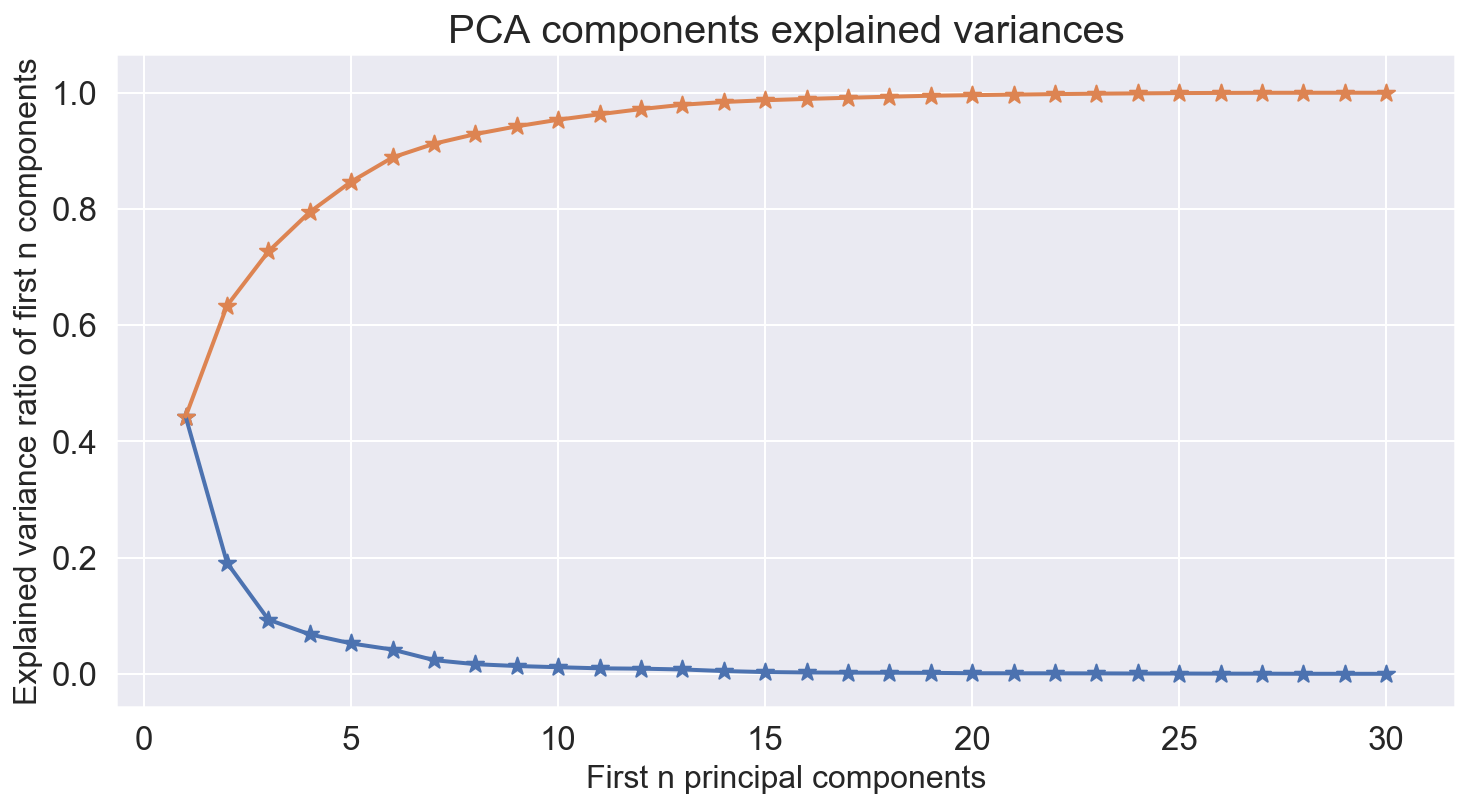

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
x_values = list(range(1, pca.n_components_+1))
ax.plot(x_values, explained_variance_ratio, lw=2)
ax.scatter(x_values, explained_variance_ratio, marker='*', s=80)
ax.plot(x_values, np.cumsum(explained_variance_ratio), lw=2)
ax.scatter(x_values, np.cumsum(explained_variance_ratio), marker='*', s=80)
ax.set_title('PCA components explained variances', fontsize=20)
ax.set_xlabel('First n principal components', fontsize=16)
ax.set_ylabel('Explained variance ratio of first n components', fontsize=16)
plt.show()

Scikit-plot offers the following implementation which allows to fix the desired level of explained variance and determines how many components are necessary to achieve it.


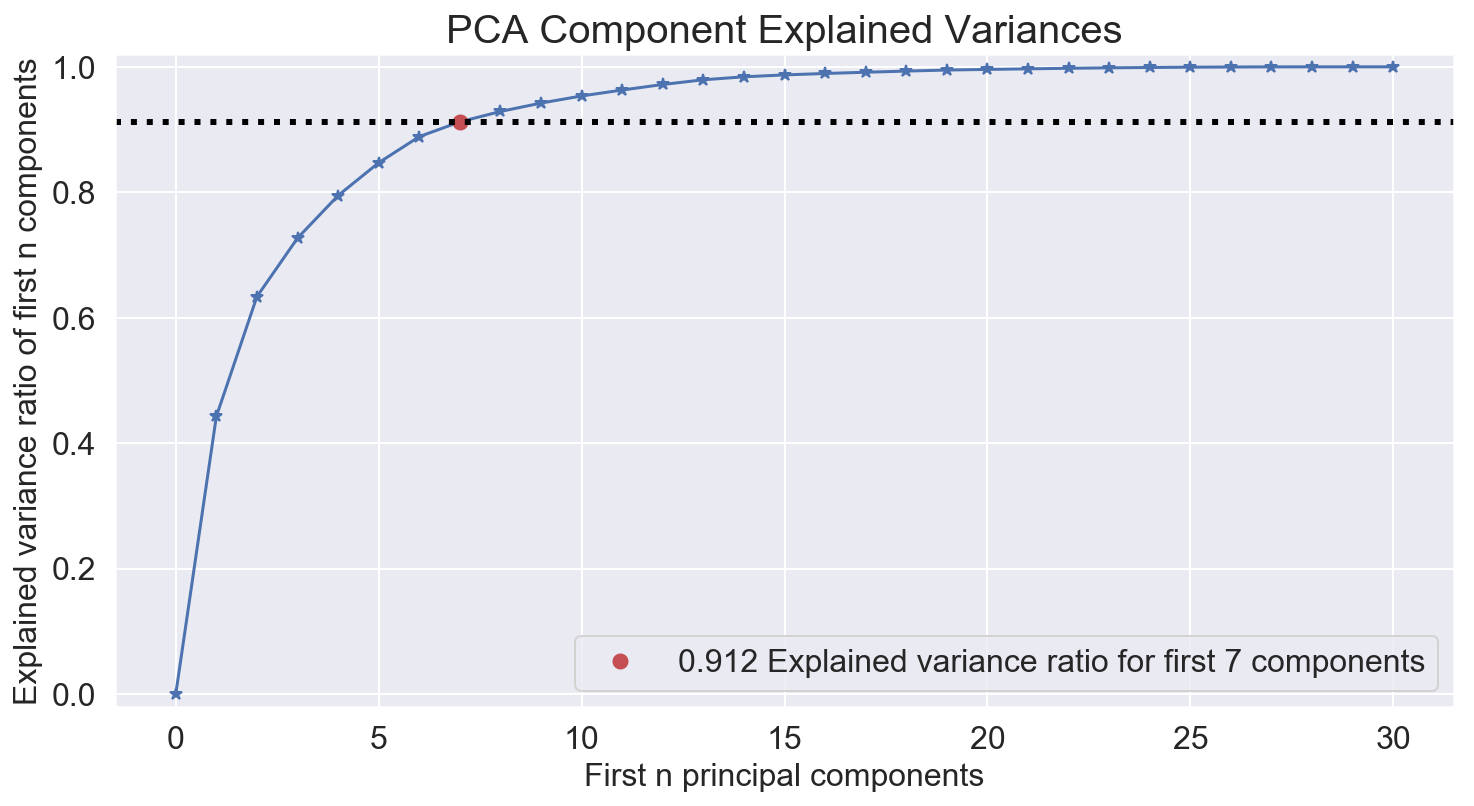

In [22]:
skplt.decomposition.plot_pca_component_variance(
        pca, 
        target_explained_variance=0.9,
        figsize=(12, 6), title_fontsize=20, text_fontsize=16)
plt.show()

The first two principal components which define the directions of highest variance can serve to depict the data in a scatter plot. They offer the best angle to look at the data since it is stretched out the most along these directions.

We can also see how the original coordinate axes are aligned with the two first principal components. Note that these directions are only defined up to a sign. 

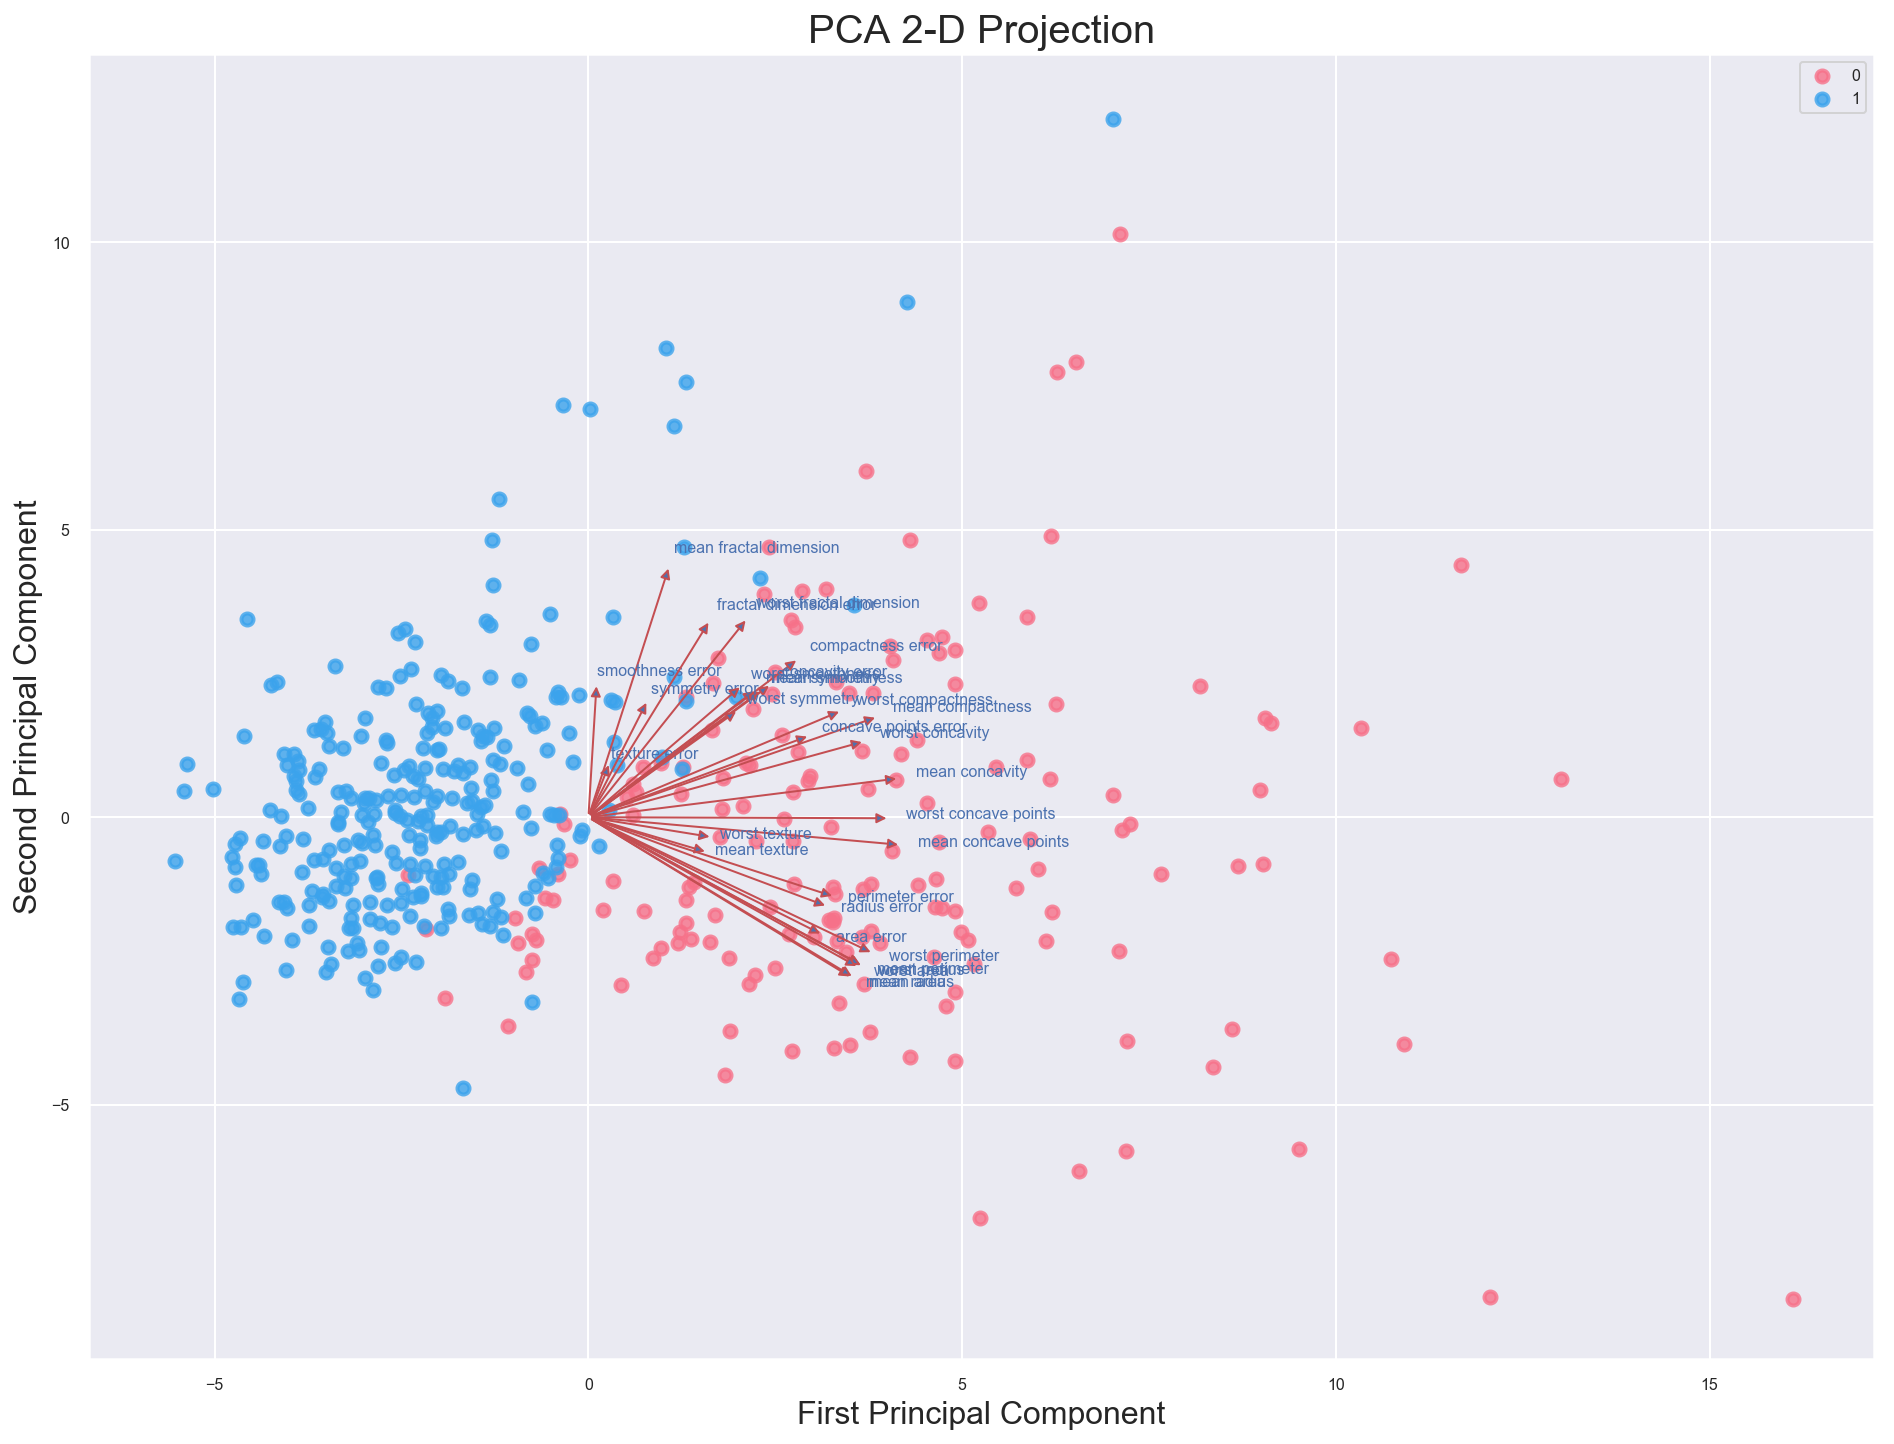

In [23]:
fig, ax = plt.subplots(figsize=(16, 12))
skplt.decomposition.plot_pca_2d_projection(
    pca, X_train, y_train, cmap=cmap, biplot=True,
    feature_labels=X.columns.tolist(), 
    title_fontsize=20, text_fontsize=8, ax=ax)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
plt.show()

## Grid search a logistic regression model

We can use the data expressed in the new coordinates to fit our model. So far we have not neglected anything, so we must recover exactly the same results.

In [24]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
estimator = LogisticRegression(solver='liblinear')

In [25]:
from sklearn.model_selection import cross_val_score, GridSearchCV

params = {'C': np.logspace(-4, 4, 30), 
          'penalty': ['l1', 'l2'], 
          'fit_intercept': [True, False],}

model = GridSearchCV(estimator=estimator, param_grid=params,
                  cv=5, return_train_score=True)

model.fit(X_pca_train, y_train)

print('Best Parameters:')
print(model.best_params_)
print('Best estimator C:')
print(model.best_estimator_.C)
print('Best estimator mean cross validated training score:')
print(model.best_score_)
print('Best estimator score on the full training set:')
print(model.score(X_pca_train, y_train))
print('Best estimator score on the test set:')
print(model.score(X_pca_test, y_test))
print('Best estimator coefficients:')
print(model.best_estimator_.coef_)

Best Parameters:
{'C': 0.20433597178569418, 'fit_intercept': True, 'penalty': 'l2'}
Best estimator C:
0.20433597178569418
Best estimator mean cross validated training score:
0.9802197802197802
Best estimator score on the full training set:
0.9846153846153847
Best estimator score on the test set:
0.9912280701754386
Best estimator coefficients:
[[-1.75182235  0.86137731  0.33861642  0.37057891  0.64037192  0.25527097
  -0.06739823 -0.36307333 -0.49090087  0.08721663 -0.3122647   0.01662426
  -0.21006097  0.38759468 -0.15631337 -0.05572113  0.02082285 -0.22220216
   0.06912804  0.04666291 -0.02393461 -0.01462439  0.10133755 -0.08538933
  -0.05616573  0.03304206 -0.01222427  0.00347079  0.01116141 -0.00645224]]


## Retaining only two components

Now we are going to restrict to fewer components, for example to just 2 (which might turn out to be too drastic).

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=1)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [27]:
pca = PCA(n_components=2)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)
X_pca_train.shape

(455, 2)

Principal components expressed through original coordinates:

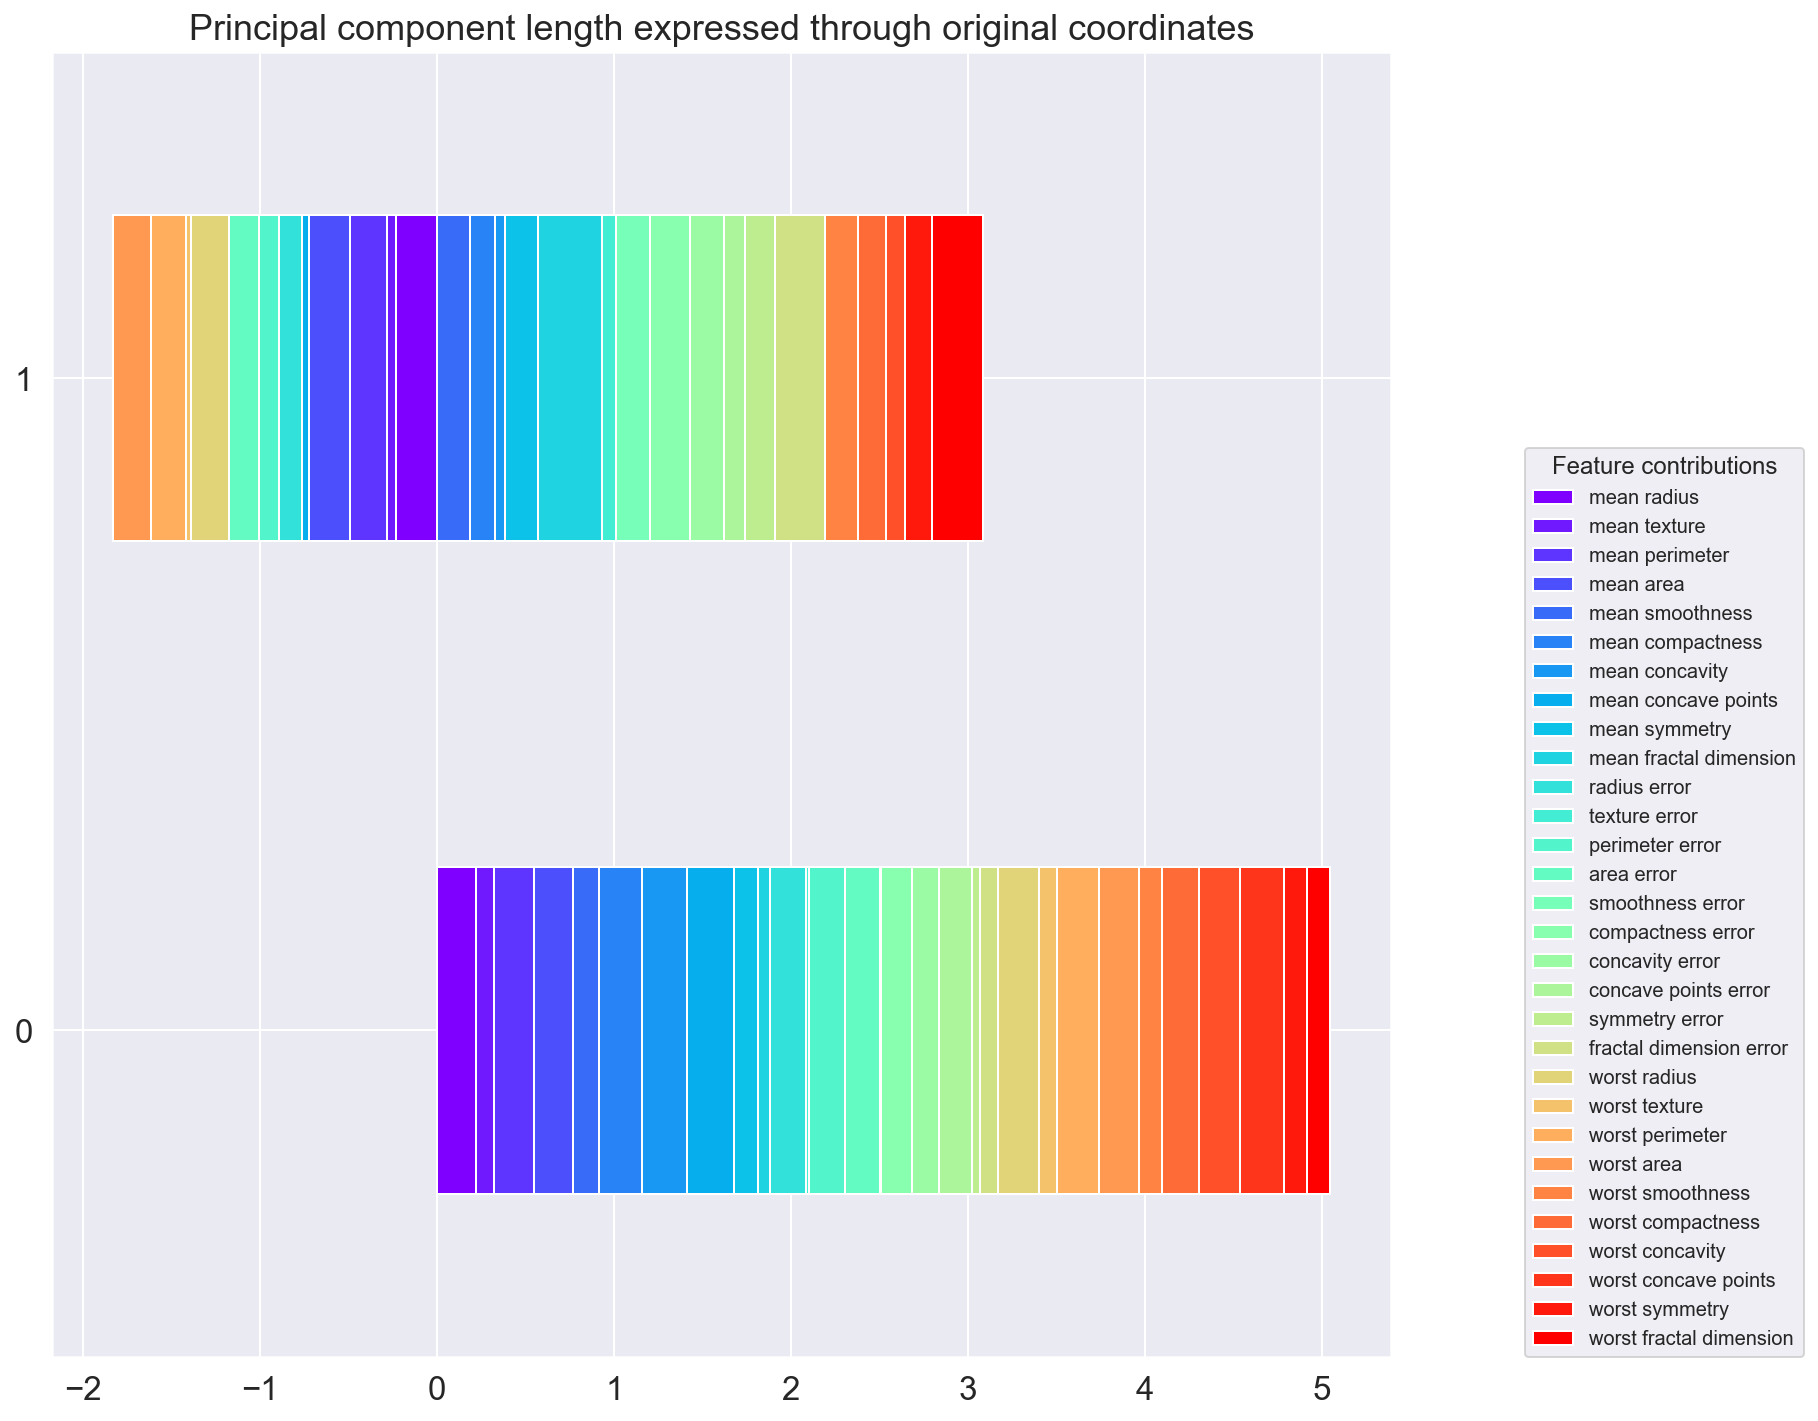

In [28]:
fig, ax = plt.subplots(figsize=(12, 12))
pd.DataFrame(pca.components_, index=list(range(pca.n_components_)), columns=X.columns
             ).plot(kind='barh', stacked=True, ax=ax, cmap='rainbow')
ax.legend(loc=[1.1, 0], fontsize=10, title_fontsize=12, title='Feature contributions')
ax.set_title('Principal component length expressed through original coordinates')
plt.show()

Original coordinates expressed through principal components:

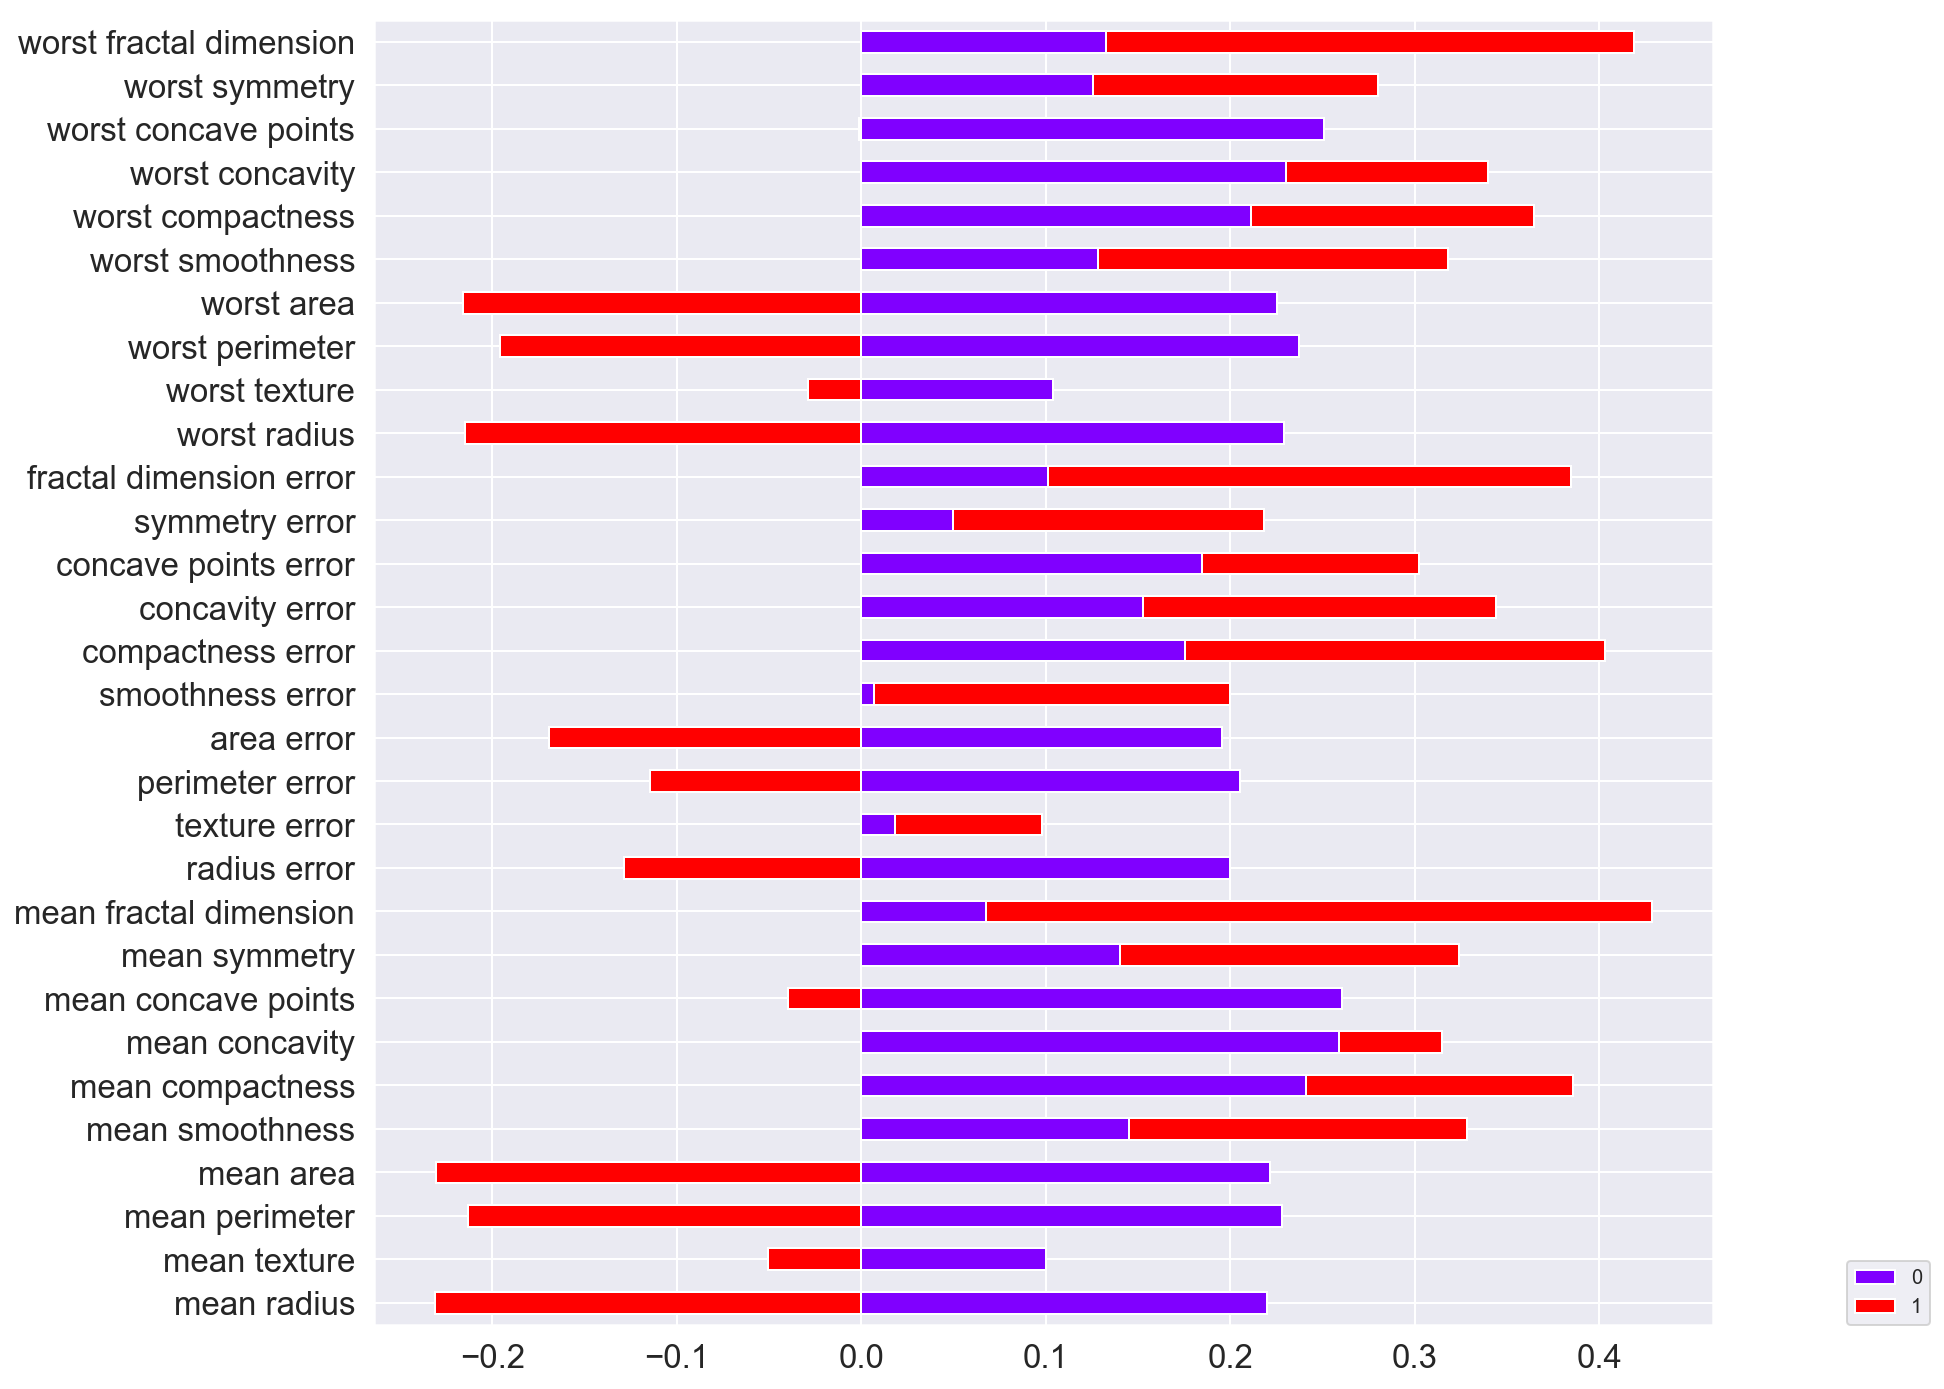

In [29]:
fig, ax = plt.subplots(figsize=(12, 12))
pd.DataFrame(pca.components_.T, columns=list(range(pca.n_components_)), index=X.columns
             ).plot(kind='barh', stacked=True, ax=ax, cmap='rainbow')
ax.legend(loc=[1.1, 0], fontsize=10)
plt.show()

In [30]:
params = {'C': np.logspace(-4, 4, 30), 
          'penalty': ['l1', 'l2'], 
          'fit_intercept': [ True, False]}

model = GridSearchCV(estimator=estimator, param_grid=params,
                  cv=5, return_train_score=True)

model.fit(X_pca_train, y_train)

print('Best Parameters:')
print(model.best_params_)
print('Best estimator C:')
print(model.best_estimator_.C)
print('Best estimator mean cross validated training score:')
print(model.best_score_)
print('Best estimator score on the full training set:')
print(model.score(X_pca_train, y_train))
print('Best estimator score on the test set:')
print(model.score(X_pca_test, y_test))
print('Best estimator coefficients:')
print(model.best_estimator_.coef_)

Best Parameters:
{'C': 0.03039195382313198, 'fit_intercept': False, 'penalty': 'l2'}
Best estimator C:
0.03039195382313198
Best estimator mean cross validated training score:
0.9516483516483516
Best estimator score on the full training set:
0.9494505494505494
Best estimator score on the test set:
0.9473684210526315
Best estimator coefficients:
[[-1.09530381  0.4971824 ]]


Having restricted to only two  components it becomes straight-forward to plot the data and the decision boundary of the model.

In [31]:
# create a mesh to plot in
x_min, x_max = X_pca_train[:, 0].min() - 1, X_pca_train[:, 0].max() + 1
y_min, y_max = X_pca_train[:, 1].min() - 1, X_pca_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .01),
                     np.arange(y_min, y_max, .01))

In [32]:
Z = model.predict((np.c_[xx.ravel(), yy.ravel()]))

In [33]:
Z = Z.reshape(xx.shape)

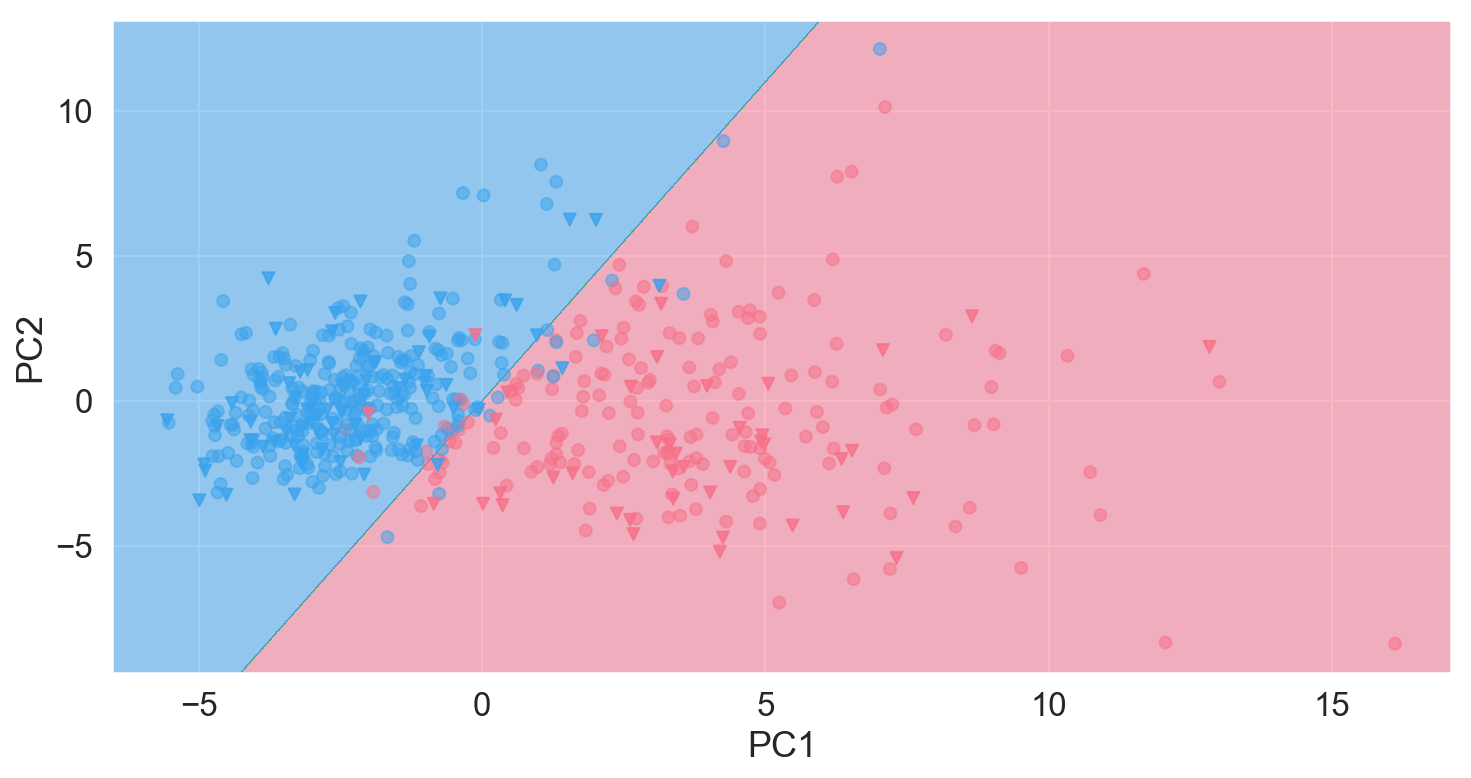

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)
ax.scatter(X_pca_train[:, 0], X_pca_train[:, 1],
           c=y_train, cmap=cmap, alpha=0.5)
ax.scatter(X_pca_test[:, 0], X_pca_test[:, 1],
           c=y_test, marker='v', cmap=cmap, alpha=0.8)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

## Clustering


Principal component analysis is often used as a preprocessing step for cluster analysis. This is on the one hand because clustering algorithms might face challenges with large datasets in terms of computational cost, on the other because reducing the dimensionality makes visual inspection simpler.

We are going to try out three frequently used clustering algorithms, KMeans, Agglomerative Hierarchical Clustering and DBSCAN (Density Based Spatial Clustering for Applications with Noise). We will fit them on the dimensionally reduced data for now.

### K-Means

In K-Means we have to specify the number of clusters. The algorithm then searches for cluster centers so that each point is assigned to the cluster of the nearest centroid. The positions of the centroids are adjusted so that the mean intra-cluster variance is as low as possible.

In [35]:
from sklearn.cluster import KMeans

In [36]:
cluster = KMeans(n_clusters=2)
cluster.fit(X_pca_train)
cluster_labels = cluster.labels_

In [37]:
cluster.cluster_centers_

array([[-2.1966948 , -0.06344288],
       [ 4.33595968,  0.12522711]])

In [38]:
cluster.inertia_

4312.159661177953

We can plot the data together with the cluster centers, the assigned cluster labels through color coding and the true labels as marker symbols.

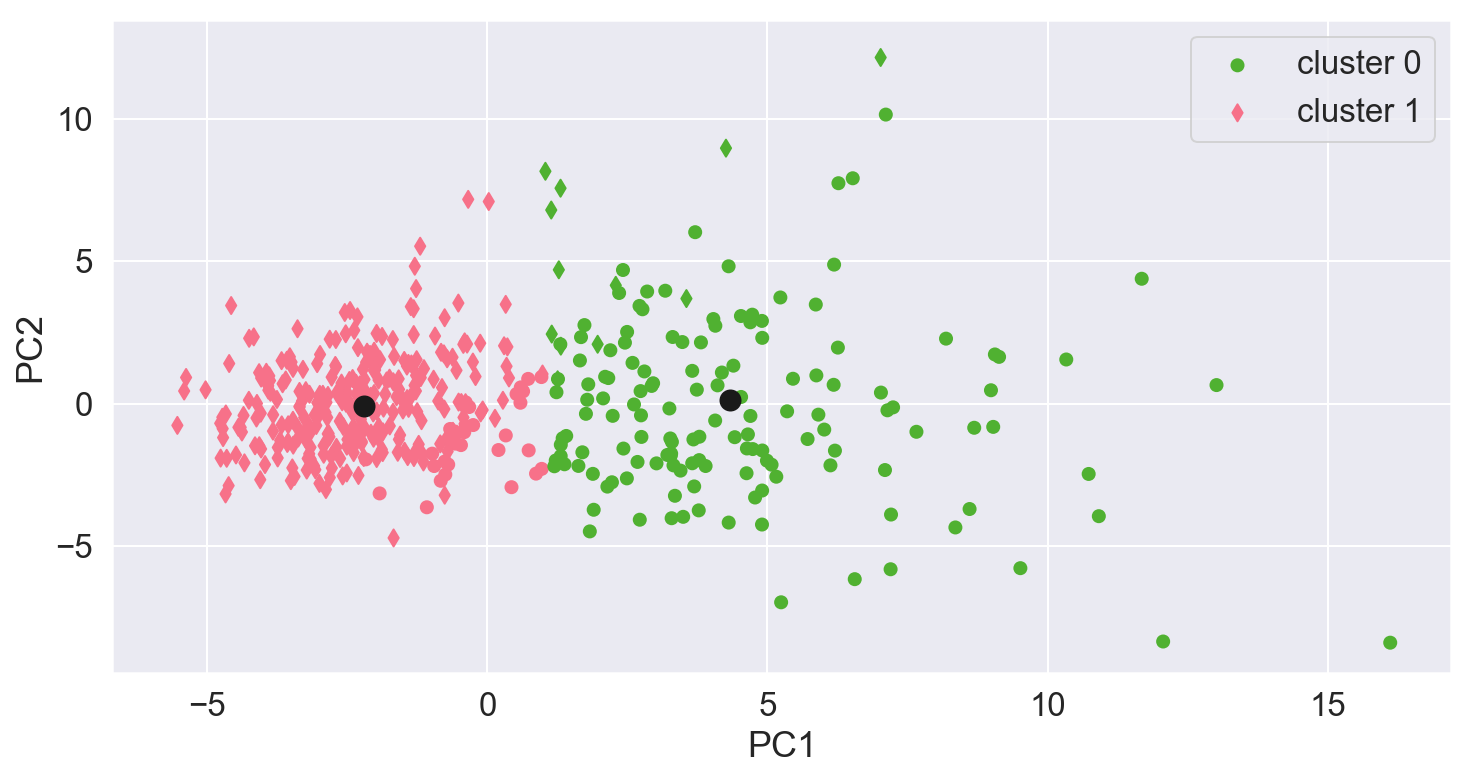

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
for i, marker in zip(y_train.unique(), ['o', 'd']):
    mask = (y_train == i)
    ax.scatter(X_pca_train[mask, 0], X_pca_train[mask, 1], marker=marker, color=cmap(
        cluster_labels[mask]), label='cluster {}'.format(i))
ax.scatter([cluster.cluster_centers_[:, 0]], [
           cluster.cluster_centers_[:, 1]], color='k', s=100)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
plt.show()

To evaluate the clustering results, there are a wide variety of measures. We distinguish two situations:

- We compare the cluster labels with existing labels (assigned or obtained from another clustering procedure)
- We try to judge the clustering results on their own

In the first case we can use scores like homogeneity, completeness or the V-measure which is the harmonic mean of the two others which can range between zero and one.

In the second case we can use the silhouette score which measures for each observation the mean distance to all the other observations assigned to the same cluster and compares it to the mean distance to all the observations in the closest other cluster. Averaging over all observations produces a single score which can range between -1 and 1.

See also [scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness).

In [40]:
metrics.homogeneity_completeness_v_measure(y_train, cluster_labels)

(0.5424707250632294, 0.5614427910194231, 0.5517937292888911)

In [41]:
metrics.silhouette_score(X_pca_train, cluster.labels_)

0.5065321242518888

K-Means is particular because we can make predictions based on the cluster centers. Any new point will be assigned to the cluster of the closest centroid. Having a predict method fits into the grid search scheme, so we can test easily for different number of clusters as long as we have some true labels.

In [42]:
gridsearch = GridSearchCV(cluster, 
                          param_grid={'n_clusters': [2, 3, 4]}, 
                          scoring='homogeneity_score', 
                          cv=5, 
                          return_train_score=True)
gridsearch.fit(X_pca_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_clusters': [2, 3, 4]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='homogeneity_score',
       verbose=0)

In [43]:
gridsearch.best_estimator_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [44]:
pd.DataFrame(gridsearch.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_clusters,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.018378,0.000911,0.001409,0.000231,2,{'n_clusters': 2},0.487838,0.536751,0.506338,0.612109,...,0.563584,0.069968,2,0.612903,0.542857,0.552612,0.500978,0.566851,0.555240,0.036234
1,0.033244,0.004753,0.001296,0.000011,3,{'n_clusters': 3},0.456641,0.588403,0.499337,0.578748,...,0.518042,0.055413,3,0.505111,0.604888,0.473096,0.461372,0.480901,0.505074,0.051922
2,0.048605,0.009545,0.001710,0.000331,4,{'n_clusters': 4},0.576192,0.633568,0.574777,0.777814,...,0.627297,0.078601,1,0.599527,0.629927,0.628411,0.546269,0.581511,0.597129,0.031275


Another way to judge the quality of the clustering is by looking at the inertia for different numbers of clusters. Increasing the number of clusters will reduce the inertia, but maybe only significantly initially. Therefore a good number of clusters could be where the decrease in inertia slows down, that is one observes some kind of elbow structure in the below plot. We verify again that the results agree.

> **Note:** The elbow plot is only suitable for K-Means clustering.

In [45]:
inertia = []
for k in range(1, 10):
    cluster_k = KMeans(n_clusters=k)
    cluster_k.fit(X_pca_train)
    inertia.append(cluster_k.inertia_)

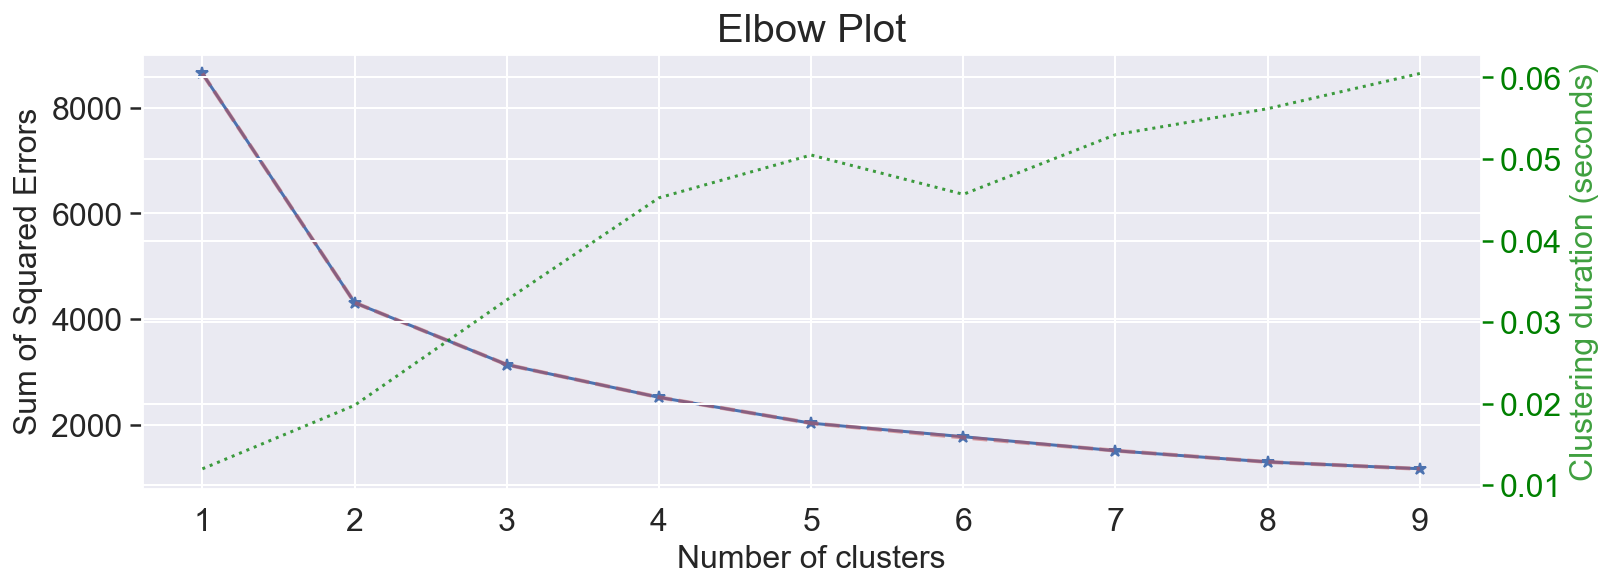

In [46]:
fig, ax = plt.subplots(figsize=(12, 4))
skplt.cluster.plot_elbow_curve(cluster, X_pca_train, cluster_ranges=range(
    1, 10), title_fontsize=20, text_fontsize=16, ax=ax)
ax.plot(range(1, 10), inertia, color='r',
        linestyle='--', linewidth=2, alpha=0.5)
plt.show()

The silhouette scores are typically depicted in the following way. The wedges represent the silhouette scores for each individual observation grouped by clusters. The dashed line marks the mean silhouette score.

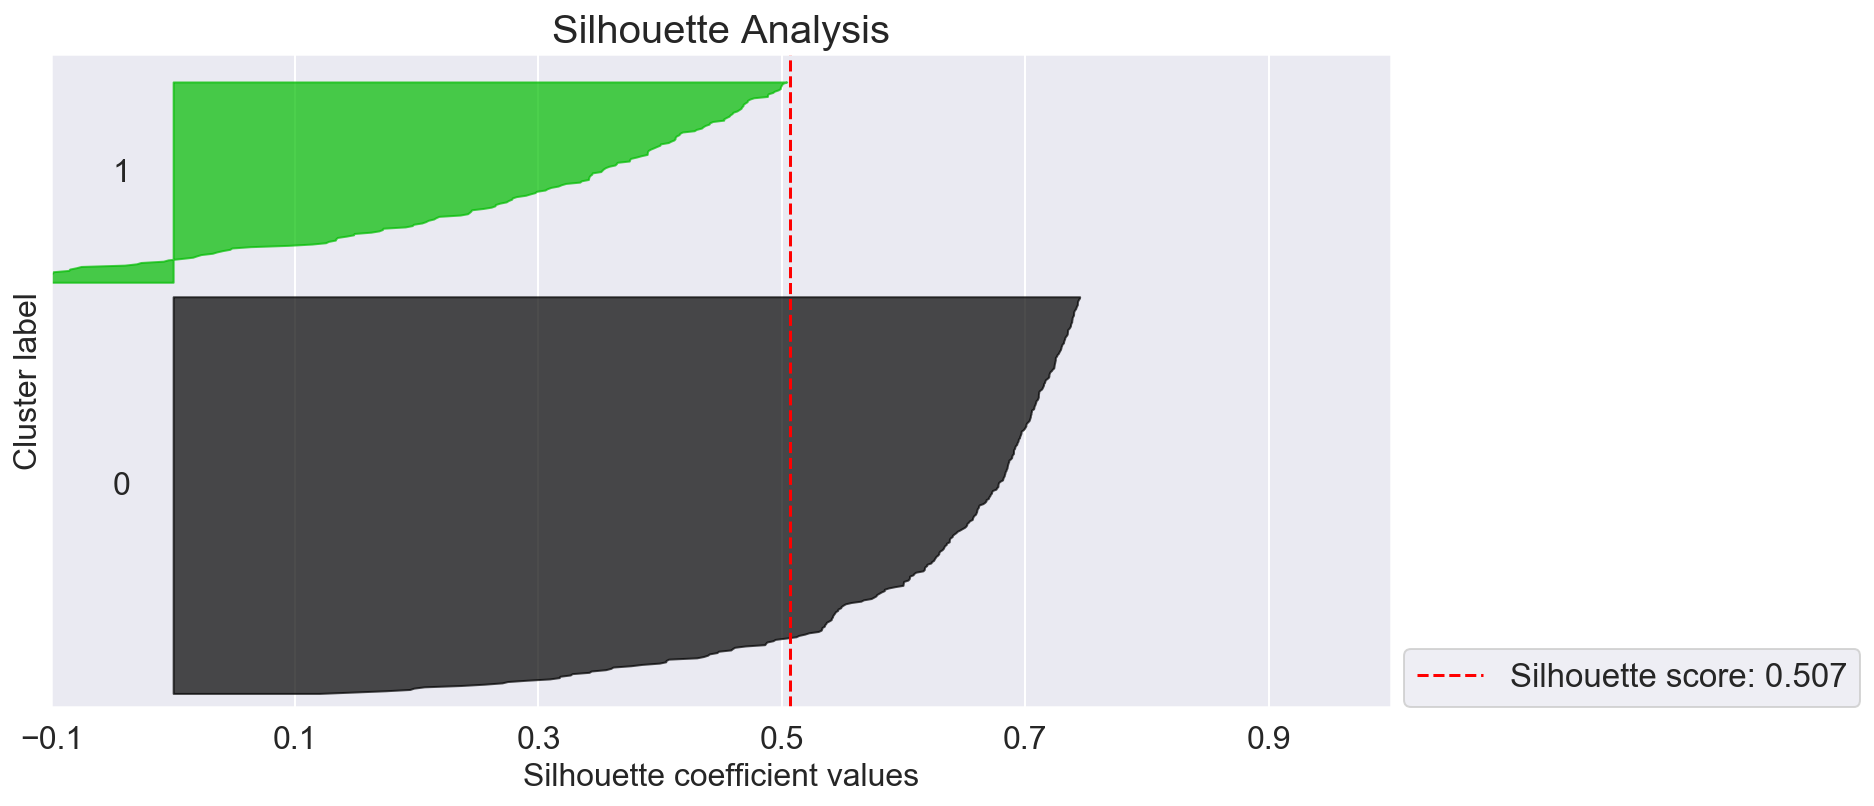

In [47]:
fig, ax = plt.subplots(figsize=(12, 6))
skplt.metrics.plot_silhouette(
    X_pca_train, cluster.labels_, title_fontsize=20, text_fontsize=16, ax=ax)
ax.legend(loc=[1.01, 0])
plt.show()

### Hierarchical clustering

In agglomerative hierarchical clustering we build clusters from the bottom where each observation is in its own cluster, then subsequently combining observations into clusters until all the observations are contained in a single cluster. We have to decide which subclusters are to be considered so similar that they should be joined next. This requires the choice of a similarity measure. Additionally we have to decide how distances to clusters are measured which contain already more than one observation. This requires the choice of a linkage. In scikit-learn, the number of clusters, the similarity measure and the linkage can all be chosen from a variety of options.

In [48]:
from sklearn.cluster import AgglomerativeClustering

In [49]:
cluster = AgglomerativeClustering(
    n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit(X_pca_train)
cluster_labels = cluster.labels_

In [50]:
metrics.homogeneity_completeness_v_measure(y_train, cluster_labels)

(0.4138755605098817, 0.41842595471022087, 0.4161383185558145)

In [51]:
metrics.silhouette_score(X_pca_train, cluster.labels_)

0.4734433509718882

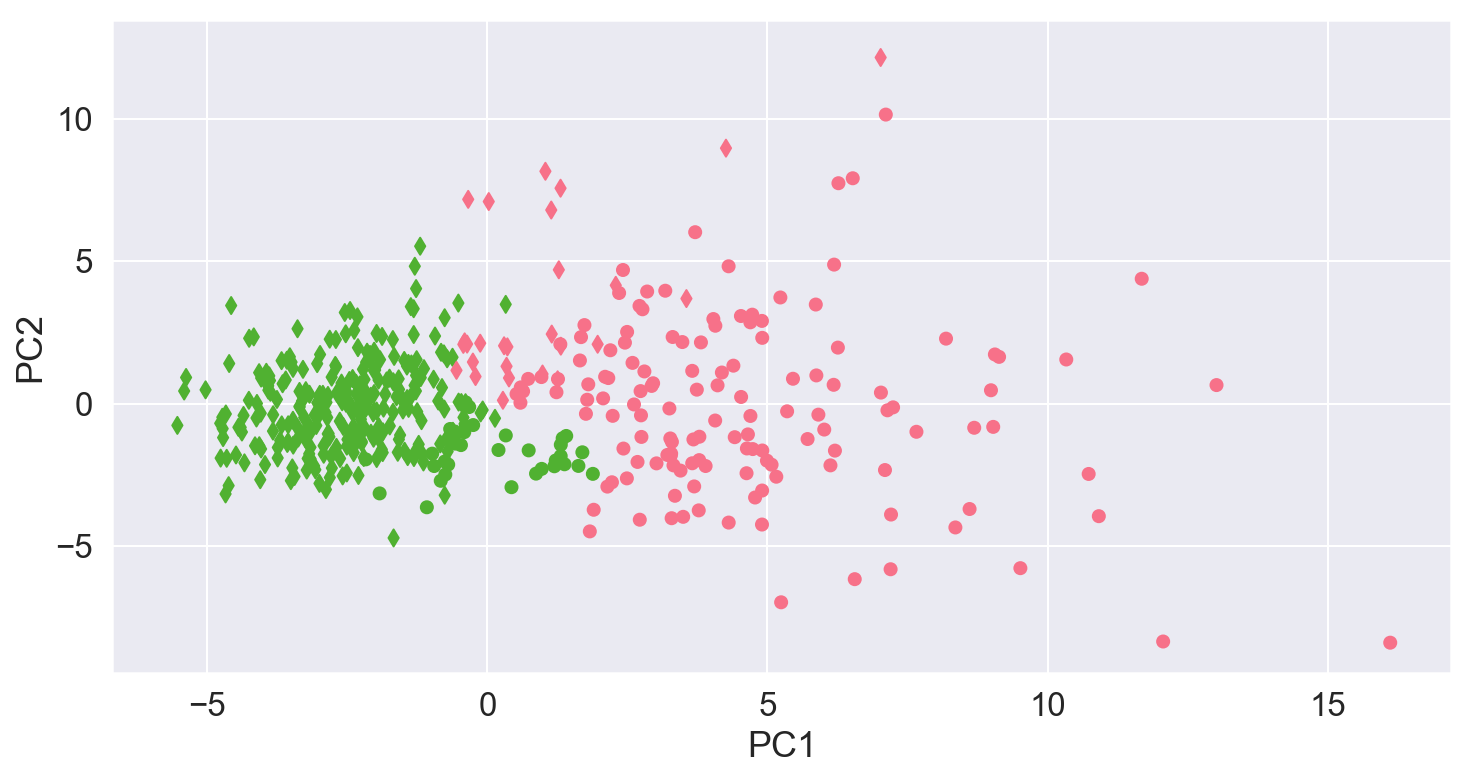

In [52]:
fig, ax = plt.subplots(figsize=(12, 6))
for i, marker in zip(y_train.unique(), ['o', 'd']):
    mask = (y_train == i)
    ax.scatter(X_pca_train[mask, 0], X_pca_train[mask, 1],
               marker=marker, color=cmap(cluster_labels[mask]))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

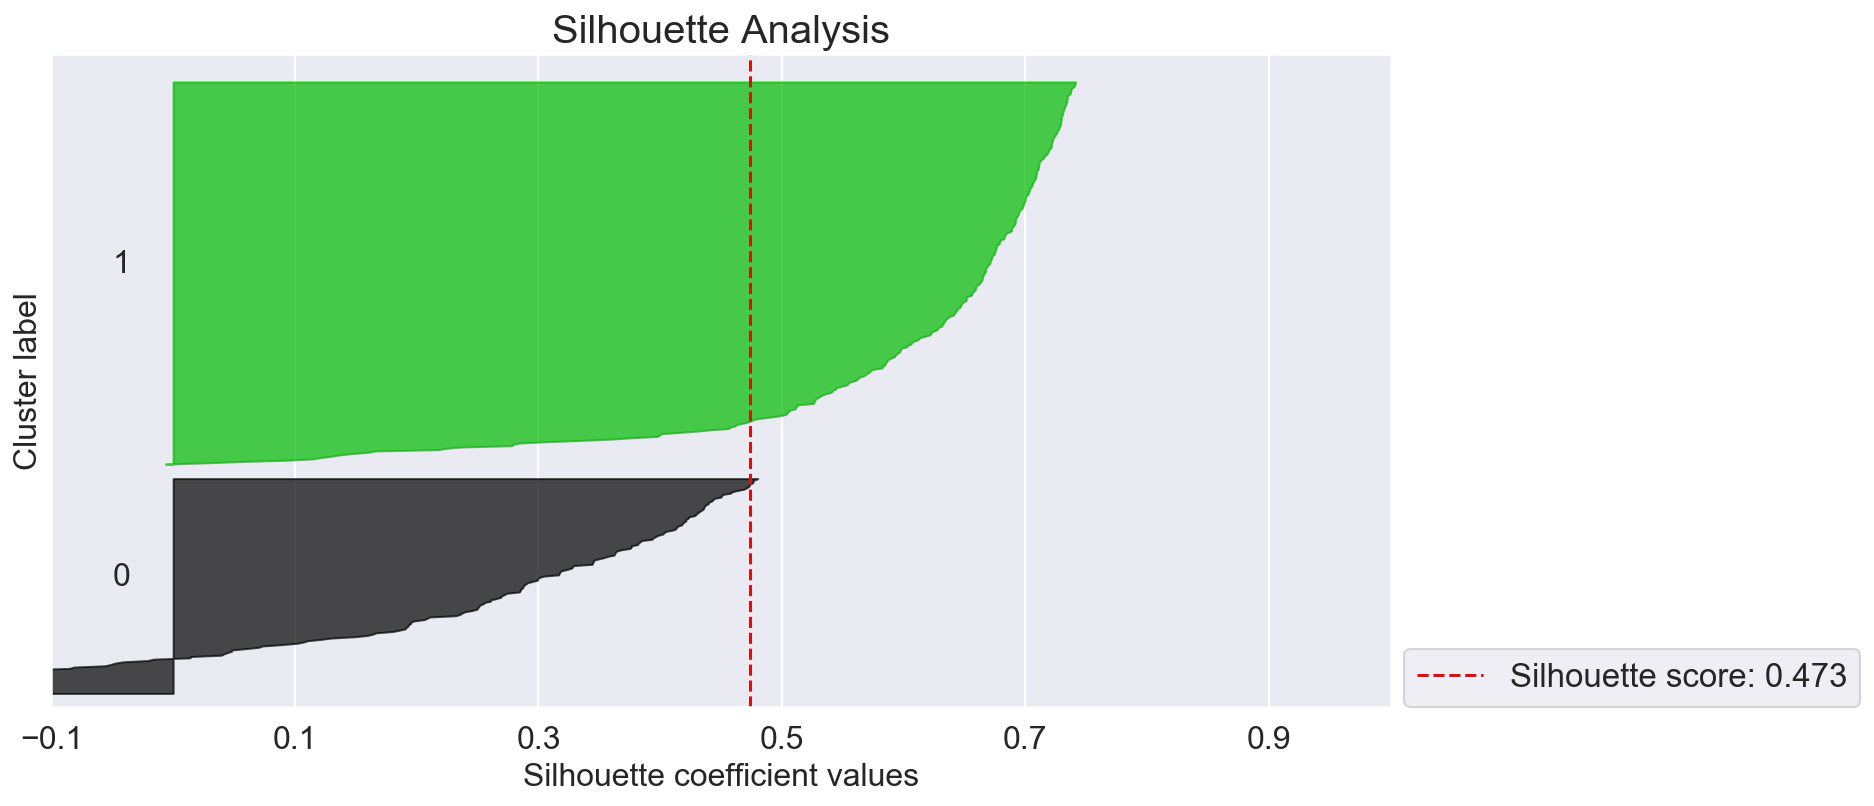

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))
skplt.metrics.plot_silhouette(
    X_pca_train, cluster.labels_,
    title_fontsize=20, text_fontsize=16, ax=ax)
ax.legend(loc=[1.01, 0])
plt.show()

The hierarchy of clusters can be represented through a dendrogramme which can be obtained with scipy.

In [54]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

We define the linkage, that is the information about which observations were joined into a single cluster at which iteration step and what was the size of the similarity leading to that  joining.

In [55]:
Z = linkage(X_pca_train, method='ward', metric='euclidean')
Z.shape

(454, 4)

The dendrogram structure is deterministic, but we have various options what to report, for example going down only to a certain level.

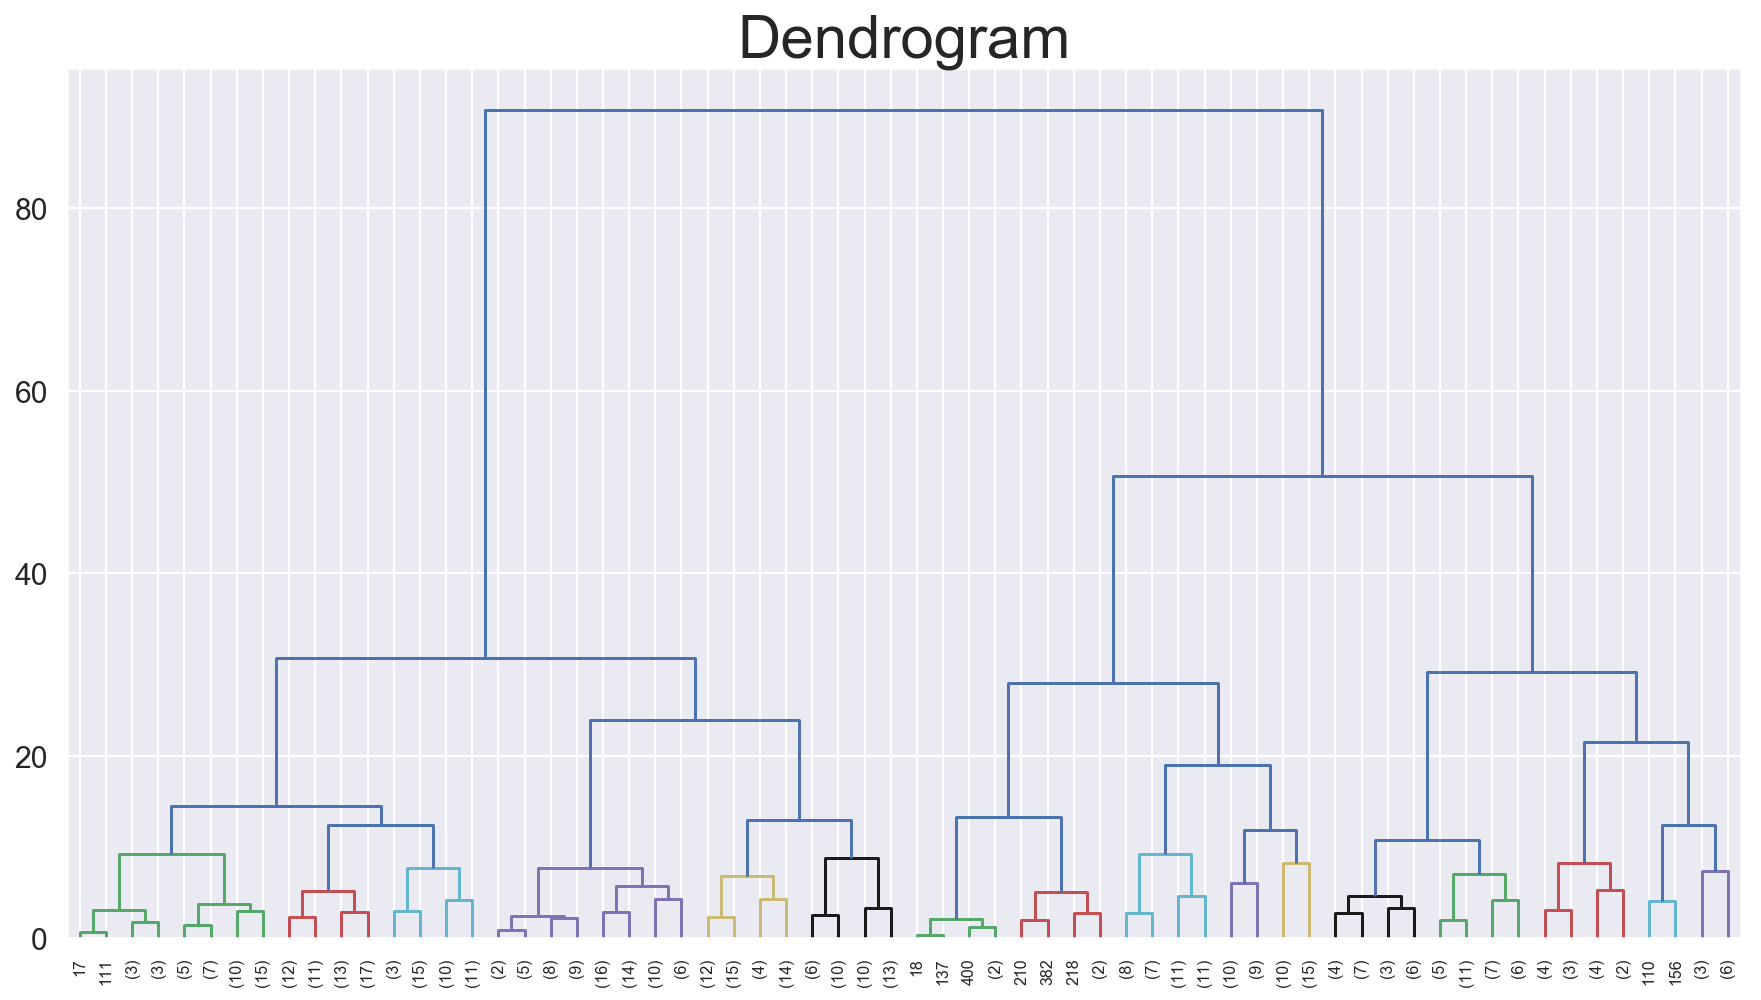

In [56]:
plt.figure(figsize=(15, 8))
dendrogram(
    Z,
    orientation='top',
    leaf_rotation=90.,
    leaf_font_size=8.,
    color_threshold=10,
    p=5,
    truncate_mode='level'
  #  truncate_mode='lastp'
)
plt.yticks(fontsize=15.)
plt.title('Dendrogram', fontsize=30)
plt.show()

### DBSCAN

DBSCAN works in a different way. It does not have a predefined number of cluster, but instead one fixes a similarity measure and the number of observations that have to be within a distance defined by the similarity measure to be able to build a cluster. That criterion may be fulfilled in high-density regions of feature space, but in low-density regions points may not be qualified to be part of any cluster.

In [57]:
from sklearn.cluster import DBSCAN

In [58]:
cluster = DBSCAN(eps=0.5, min_samples=5)
cluster.fit(X_pca_train)
cluster_labels = cluster.labels_

In [59]:
metrics.homogeneity_completeness_v_measure(y_train, cluster_labels)

(0.4346812087735294, 0.26459423425187767, 0.3289523255142644)

In [60]:
metrics.silhouette_score(X_pca_train, cluster.labels_)

-0.03652085344981922

Now we have more clusters which requires us to change the color coding scheme and make it adaptable to the number of clusters, for example in the following way.

In [61]:
from matplotlib.colors import Normalize
norm = Normalize(vmin=cluster_labels.min(), vmax=cluster_labels.max())
print(cmap(norm(-18)))

(0.9677975592919913, 0.44127456009157356, 0.5358103155058701, 1.0)


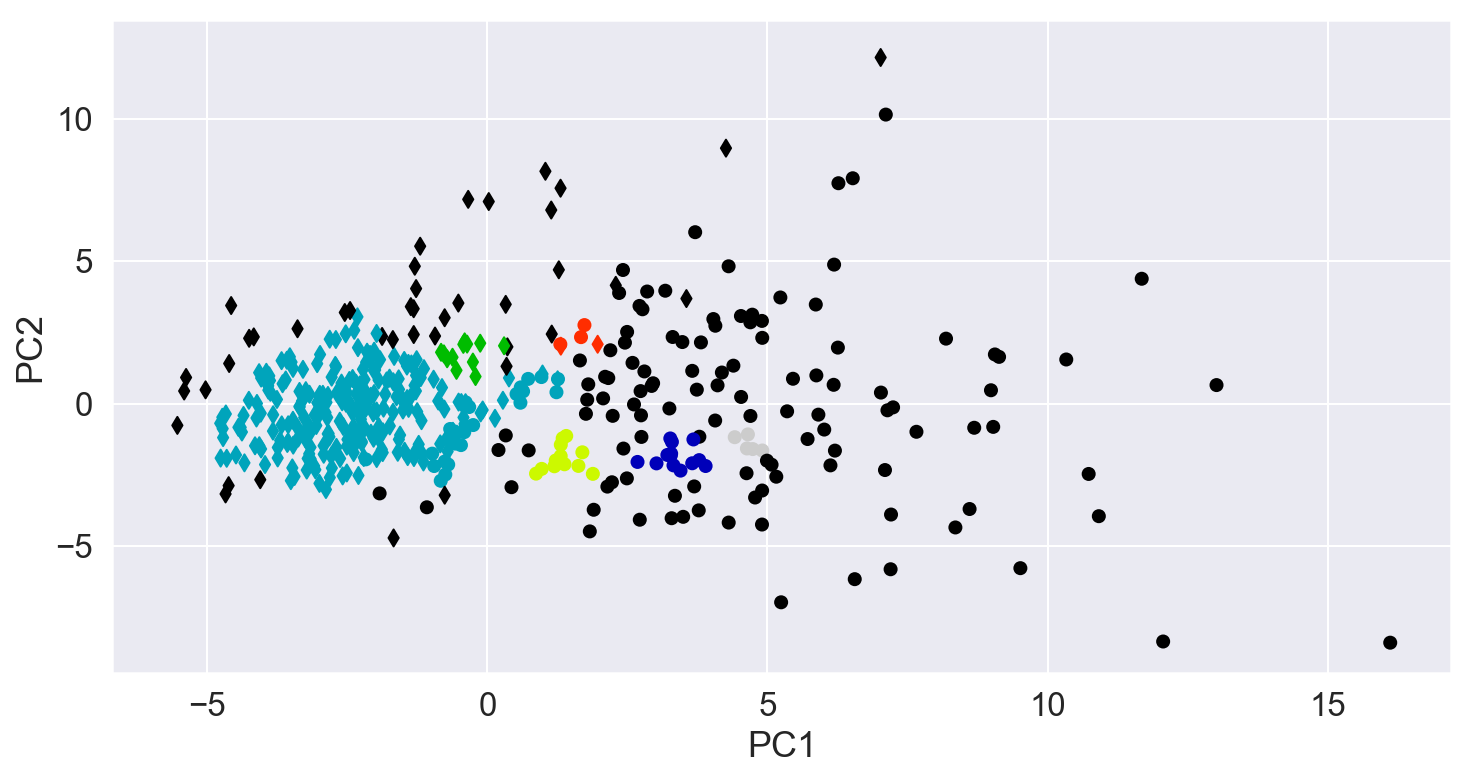

In [62]:
fig, ax = plt.subplots(figsize=(12, 6))
for i, marker in zip(y_train.unique(), ['o', 'd']):
    mask = (y_train == i)
    ax.scatter(X_pca_train[mask, 0], X_pca_train[mask, 1], marker=marker,
               color=cm.nipy_spectral(norm(cluster_labels[mask])))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

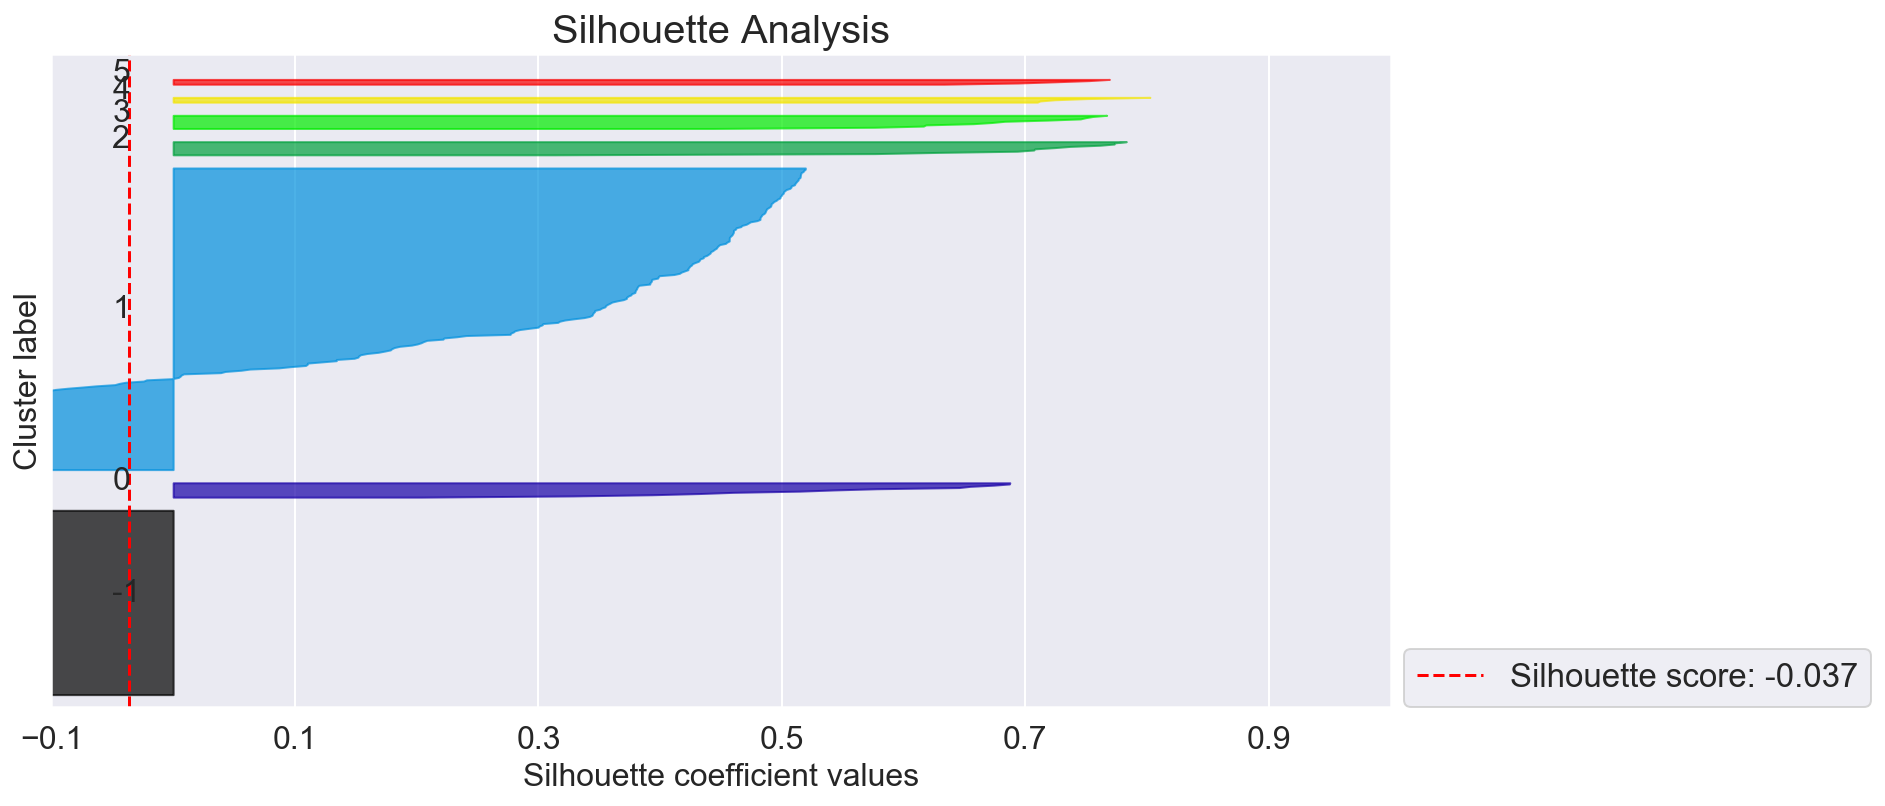

In [63]:
fig, ax = plt.subplots(figsize=(12, 6))
skplt.metrics.plot_silhouette(
    X_pca_train, cluster.labels_, title_fontsize=20, text_fontsize=16, ax=ax)
ax.legend(loc=[1.01, 0])
plt.show()